# 1. ANALISIS, TRATAMIENTO Y VISUALIZACION DE LOS DATOS 

En este notebook realizaremos las siguientes tareas principales:

- *Carga de datos*: Se importan los datos del sistema ChloroMatic Lifeguard de un archivo CSV.
- *Preprocesamiento:* Se realizan tareas de limpieza y preparación de datos, como el manejo de valores nulos y la conversión de tipos de datos.
- *Análisis exploratorio:* Se visualizan distribuciones de variables clave como pH, ORP, salinidad y temperatura mediante histogramas y diagramas de caja.
- *Detección de outliers:* Se implementa un método para detectar y eliminar valores atípicos utilizando el rango intercuartílico (IQR).
- *Visualización de series temporales:* Se crean gráficos que muestran la evolución temporal de los parámetros clave de la piscina.
- *Análisis de correlación:* Se genera una matriz de correlación para entender las relaciones entre las diferentes variables medidas.

## Carga de datos

In [2]:
#Librerias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from datetime import timedelta
from collections import Counter

In [3]:
#Mostrar los graficos
%matplotlib inline

In [4]:
# Cargamos los datos
try:
    df = pd.read_csv('../DATA/Raw_Data/Data_Pool.csv')
    print('Archivo Cargado')
    print(df.head())
    print(df.tail())
except Exception as e:
    print(f'Error en la lectura del archivo: {e}')

Archivo Cargado
      Device            Time, Hour   PH  ORP  Salinity  Temperature  \
0  Device 01  18/01/2024, 00:08:34  7.5  644      5181           25   
1  Device 01  18/01/2024, 00:10:35  6.3  742      5240           25   
2  Device 01  18/01/2024, 00:14:37  6.3  760      5233           25   
3  Device 01  18/01/2024, 00:28:42  6.5  774      5240           24   
4  Device 01  18/01/2024, 00:31:34  6.3  764      5253           24   

   Flow status  
0            1  
1            1  
2            0  
3            0  
4            0  
          Device            Time, Hour    PH  ORP  Salinity  Temperature  \
141097  Device10  18/07/2024, 10:42:52  9.68  540      3777        -9999   
141098  Device10  18/07/2024, 11:12:52  9.67  540      3782           13   
141099  Device10  18/07/2024, 11:42:53  9.60  539      4073           14   
141100  Device10  18/07/2024, 12:42:53  9.50  539      4053        -9999   
141101  Device10  18/07/2024, 13:12:53  9.50  540      4022        -9999   

## Preprocesamiento

In [5]:
#Renombramos la columa 'Time, Hour' y  pasar a Datetime format
df = df.rename(columns={'Time, Hour': 'Time'})
df['Time'] = pd.to_datetime(df['Time'], format='%d/%m/%Y, %H:%M:%S')
df['Time'].head(2)

0   2024-01-18 00:08:34
1   2024-01-18 00:10:35
Name: Time, dtype: datetime64[ns]

In [6]:
df.columns

Index(['Device', 'Time', 'PH', 'ORP', 'Salinity', 'Temperature',
       'Flow status'],
      dtype='object')

In [7]:
# Vista general de los datos con todos los dispositivos - tpo de datos y nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141102 entries, 0 to 141101
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Device       141102 non-null  object        
 1   Time         141102 non-null  datetime64[ns]
 2   PH           141102 non-null  float64       
 3   ORP          141102 non-null  int64         
 4   Salinity     141102 non-null  int64         
 5   Temperature  141102 non-null  int64         
 6   Flow status  141102 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 7.5+ MB


- No faltan datos y el tipo de dato parece correcto para cada columna

In [8]:
devices = df['Device'].unique()
print(devices)

for device in devices:
    device_data = df[df['Device'] == device]
    print(f"\nEstadísticas de {device}:")
    print(device_data.describe().to_string())

['Device 01' 'Device 02' 'Device 02.2' 'Device 03' 'Device 04' 'Device 05'
 'Device 06' 'Device 07' 'Device08' 'Device09' 'Device10']

Estadísticas de Device 01:
                                Time            PH           ORP      Salinity   Temperature   Flow status
count                          20256  20256.000000  20256.000000  20256.000000  20256.000000  20256.000000
mean   2024-04-06 01:55:26.865422592  -1199.733889   -983.362707   5334.691301     17.623519      0.383244
min              2024-01-18 00:01:34  -9999.000000  -9999.000000      0.000000      0.000000      0.000000
25%              2024-02-19 02:19:54      4.200000    548.000000   5239.000000     12.000000      0.000000
50%       2024-03-31 04:13:06.500000      6.700000    710.000000   5341.000000     17.000000      0.000000
75%    2024-05-17 08:13:08.750000128      7.500000    837.000000   5427.000000     24.000000      1.000000
max              2024-07-18 11:06:22      9.220000   1129.000000   6237.000000     31.000

- Vemos comporatmientos extraños, muchos dispositivos tienen lecturas mínimas en todos los parametros con valores de -9999 que obviamente corrompen los datos como la media. Habrá que procesar estos datos y eliminar los necesarios, pero ya a simple vista podemos saber que por ejemplo en el dispositivo 1, que la media de ph sea -1000 es incorrecta.

## Analisis Exploratorio

In [9]:
# definimos las veriables parametro y device que usaremos recurridamente
parameters = ['PH', 'ORP', 'Salinity', 'Temperature']
devices = df['Device'].unique()
print(devices)

['Device 01' 'Device 02' 'Device 02.2' 'Device 03' 'Device 04' 'Device 05'
 'Device 06' 'Device 07' 'Device08' 'Device09' 'Device10']


#### Device 01: 

Usaremos el Dispositivo 1 para ver rapidamente que opciones tenemos:

In [10]:
#Vamos a hacer la limpieza individualmente esta vez:
device_01 = df['Device'].unique()[0]
df_01 = df[df['Device'] == device_01].copy()

print(f"Analizando el dispositivo: {device_01}")
print(df_01.shape)
print(df_01.head(2))

Analizando el dispositivo: Device 01
(20256, 7)
      Device                Time   PH  ORP  Salinity  Temperature  Flow status
0  Device 01 2024-01-18 00:08:34  7.5  644      5181           25            1
1  Device 01 2024-01-18 00:10:35  6.3  742      5240           25            1


##### Limpieza de datos 1.

In [11]:
# Nulos
df_01.isnull().sum()

Device         0
Time           0
PH             0
ORP            0
Salinity       0
Temperature    0
Flow status    0
dtype: int64

In [12]:
# Duplicados
duplicates = df_01.duplicated().sum()
print(f"Número de filas duplicadas: {duplicates}")

Número de filas duplicadas: 38


In [13]:
# Eliminar duplicados
df_01.drop_duplicates(inplace=True)
duplicates = df_01.duplicated().sum()
print(f"Número de filas duplicadas: {duplicates}")

Número de filas duplicadas: 0


In [14]:
# Resetear
df_01.reset_index(drop=True, inplace=True)
print("Dimensiones del DataFrame después de la limpieza:")
print(df_01.shape)

Dimensiones del DataFrame después de la limpieza:
(20218, 7)


In [15]:
print(df_01.describe())

                                Time            PH           ORP  \
count                          20218  20218.000000  20218.000000   
mean   2024-04-06 03:32:35.162033920  -1199.527493   -983.711099   
min              2024-01-18 00:01:34  -9999.000000  -9999.000000   
25%    2024-02-19 06:30:00.249999872      4.200000    548.000000   
50%              2024-03-31 07:06:38      6.700000    710.000000   
75%              2024-05-17 08:46:17      7.500000    837.000000   
max              2024-07-18 11:06:22      9.220000   1129.000000   
std                              NaN   3257.745005   3969.028486   

           Salinity   Temperature   Flow status  
count  20218.000000  20218.000000  20218.000000  
mean    5334.630824     17.616876      0.383322  
min        0.000000      0.000000      0.000000  
25%     5239.000000     12.000000      0.000000  
50%     5341.000000     17.000000      0.000000  
75%     5427.000000     24.000000      1.000000  
max     6237.000000     31.000000    

##### Visualizacion de Datos pre-tratamiento device 01

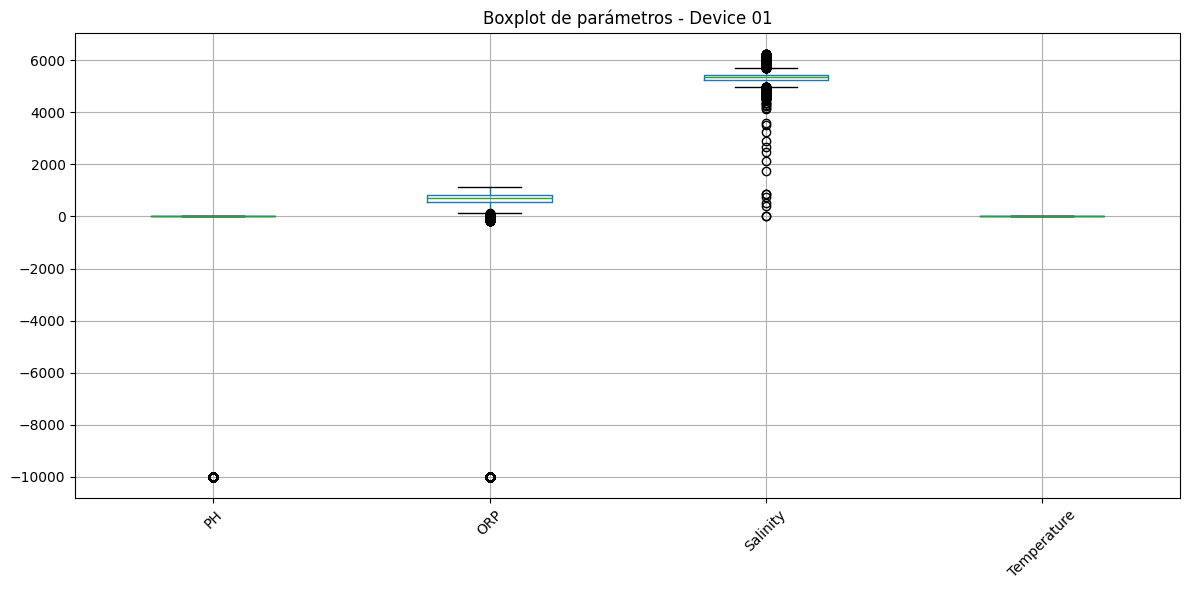

In [16]:
# Diagrama de cajas de los parámetros para ver si hay que tratar los outliers ante
plt.figure(figsize=(12, 6))
df_01[parameters].boxplot()
plt.title(f'Boxplot de parámetros - {device_01}')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Todos los datos - Representacion 

- Como hemos visto en el diagrama de cajas anterior tras un tratamiento minimo de los datos del device 1 hay claramente que eliminar esos datos anomalos, tambien eliminaremos otra vez duplicados y veremos como quedan los datos asi a primera vista:

In [17]:
# Eliminarvalores anomalos -9999
df = df[~(df[parameters] == -9999).any(axis=1)]

# Duplicados
duplicates = df_01.duplicated().sum()
print(f"Número de filas duplicadas: {duplicates}")

# Eliminar duplicados
df_01.drop_duplicates(inplace=True)
duplicates = df_01.duplicated().sum()
print(f"Número de filas duplicadas: {duplicates}")

print(f"Filas después de eliminar valores anómalos: {df.shape[0]}")
print(df.describe().to_string())

Número de filas duplicadas: 0
Número de filas duplicadas: 0
Filas después de eliminar valores anómalos: 103511
                                Time             PH            ORP       Salinity    Temperature    Flow status
count                         103511  103511.000000  103511.000000  103511.000000  103511.000000  103511.000000
mean   2024-04-13 05:47:05.839379456       7.300374     637.195515    4447.844210      20.537305       0.291814
min              2024-01-18 00:01:18       0.000000    -602.000000       0.000000     -30.000000       0.000000
25%       2024-02-23 18:28:39.500000       7.100000     584.000000    3770.000000      16.000000       0.000000
50%              2024-04-17 19:32:58       7.400000     649.000000    4293.000000      21.000000       0.000000
75%              2024-05-24 19:08:56       7.600000     685.000000    5324.000000      26.000000       1.000000
max              2024-07-18 13:09:29      10.000000    1129.000000   15427.000000      44.000000       1.

- Vamos a representar estos datos resultantes , en un tiempo acotado para ver mejor su desarrollo, especificamente queremos ver como se comporta el sistema cuando la bomba se encuentra en funcionamiento o no. Por lo que se elige representar 10 dias en Febrero (Porque el clima y uso de piscinas es mayor en esa epoca que es verano) y se elige el parametro pH para ver si encontramos algun patron de comportamiento

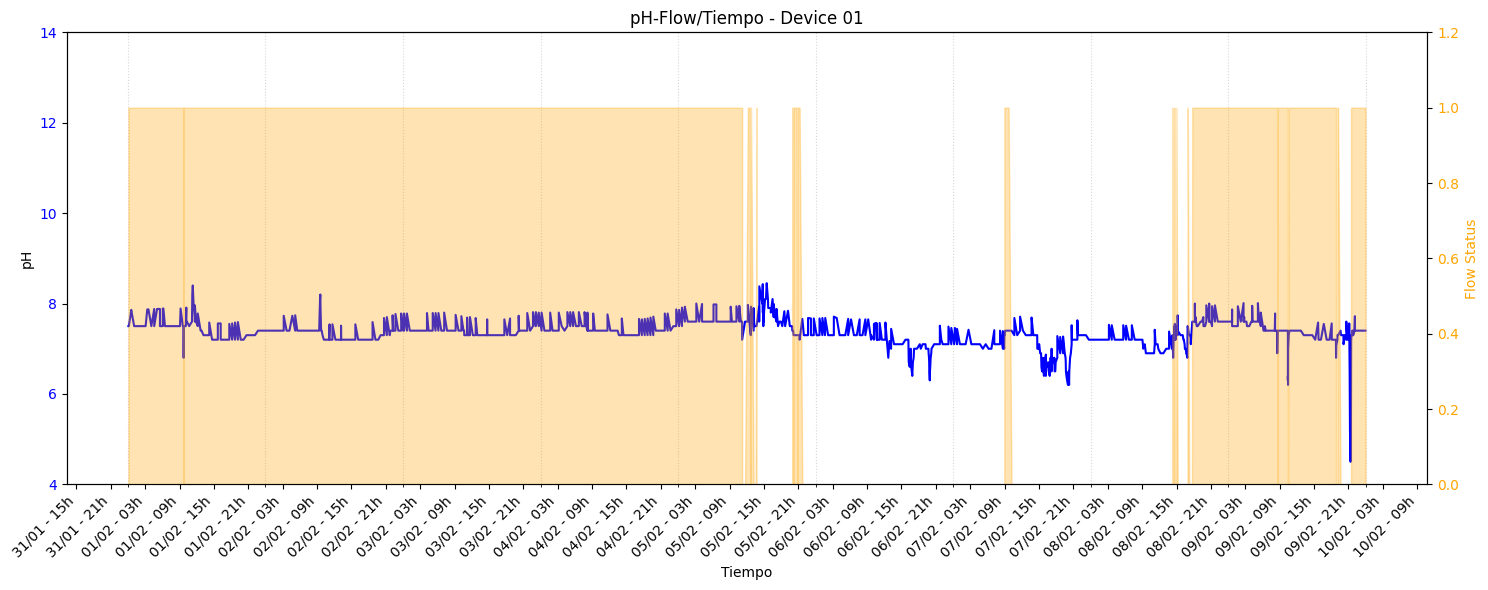

Número de activaciones: 646


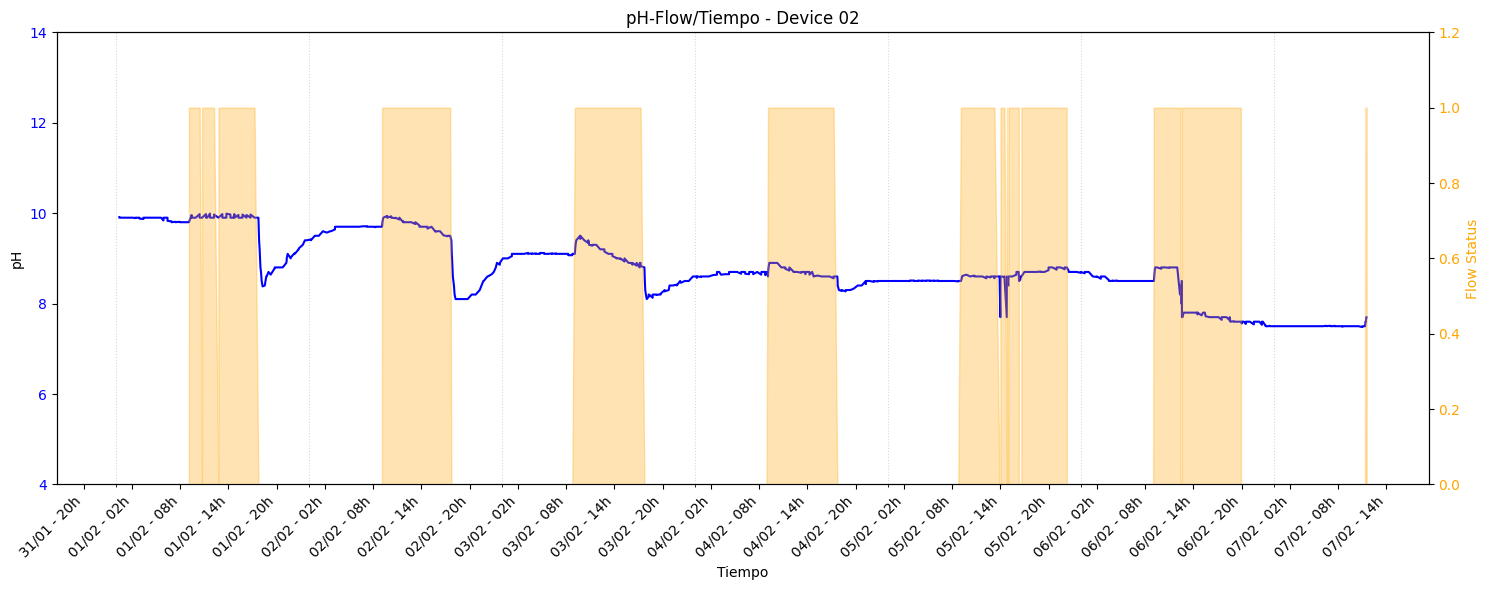

Número de activaciones: 261


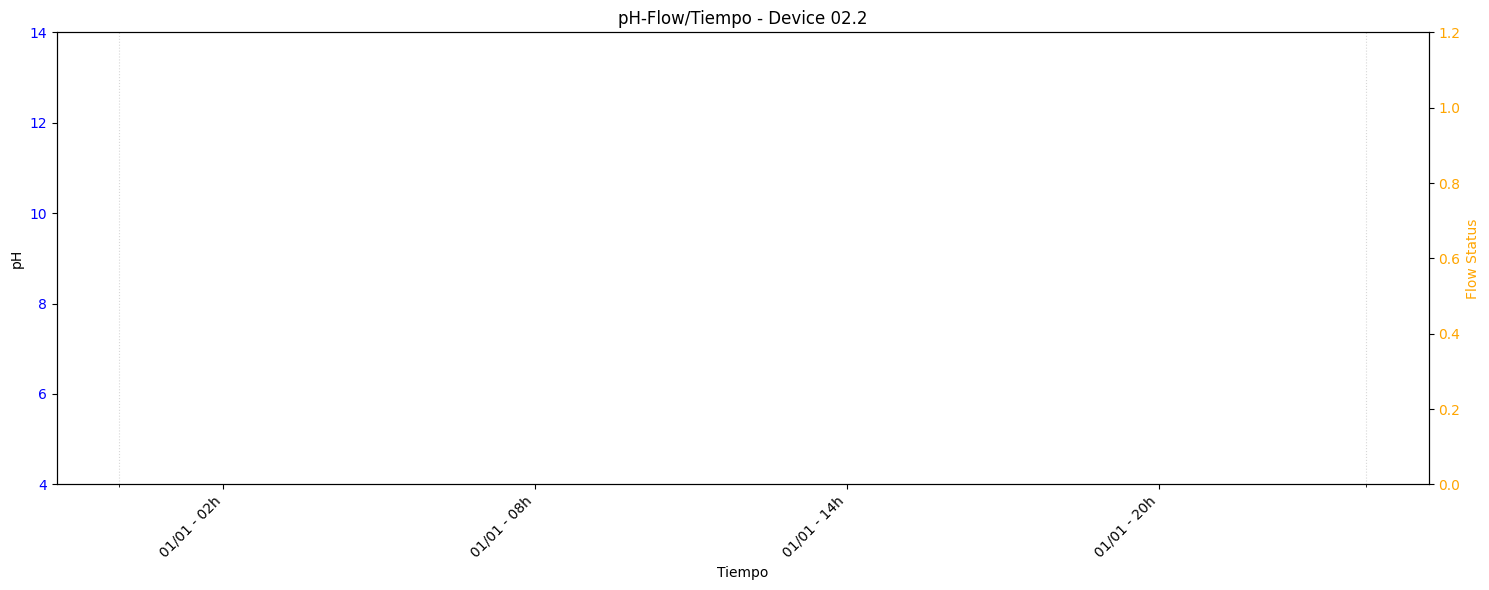

Número de activaciones: 0


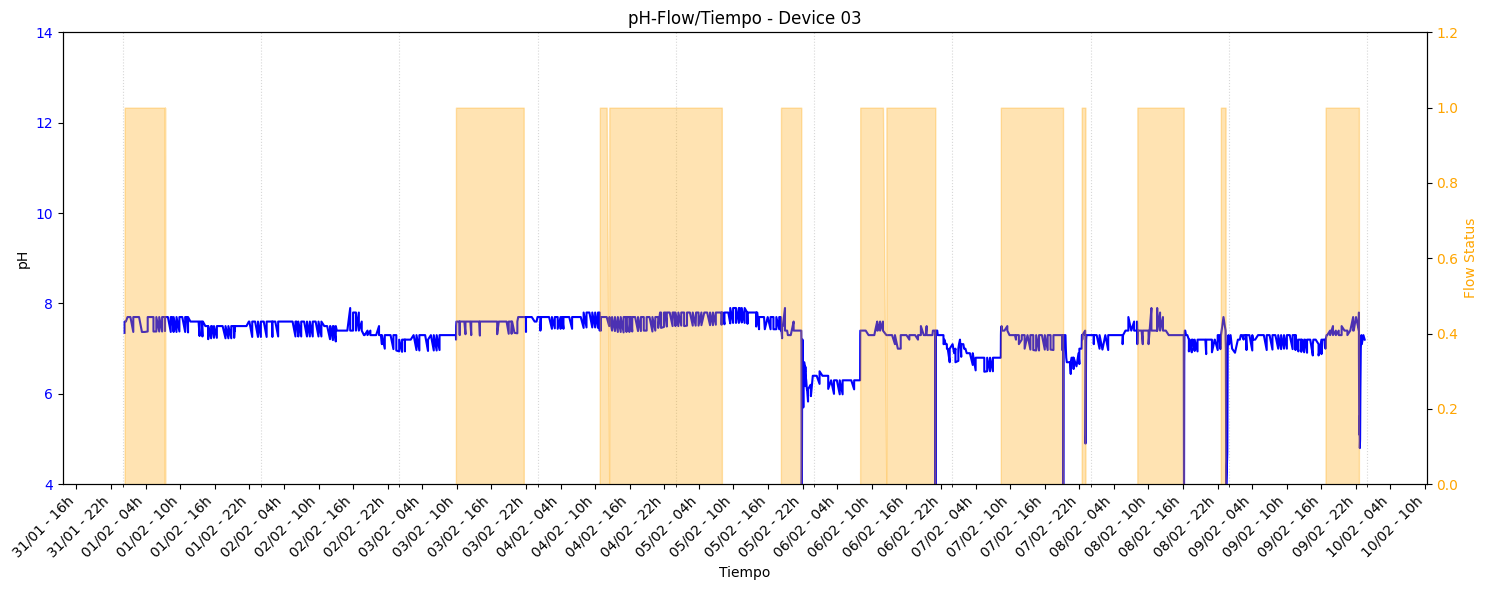

Número de activaciones: 383


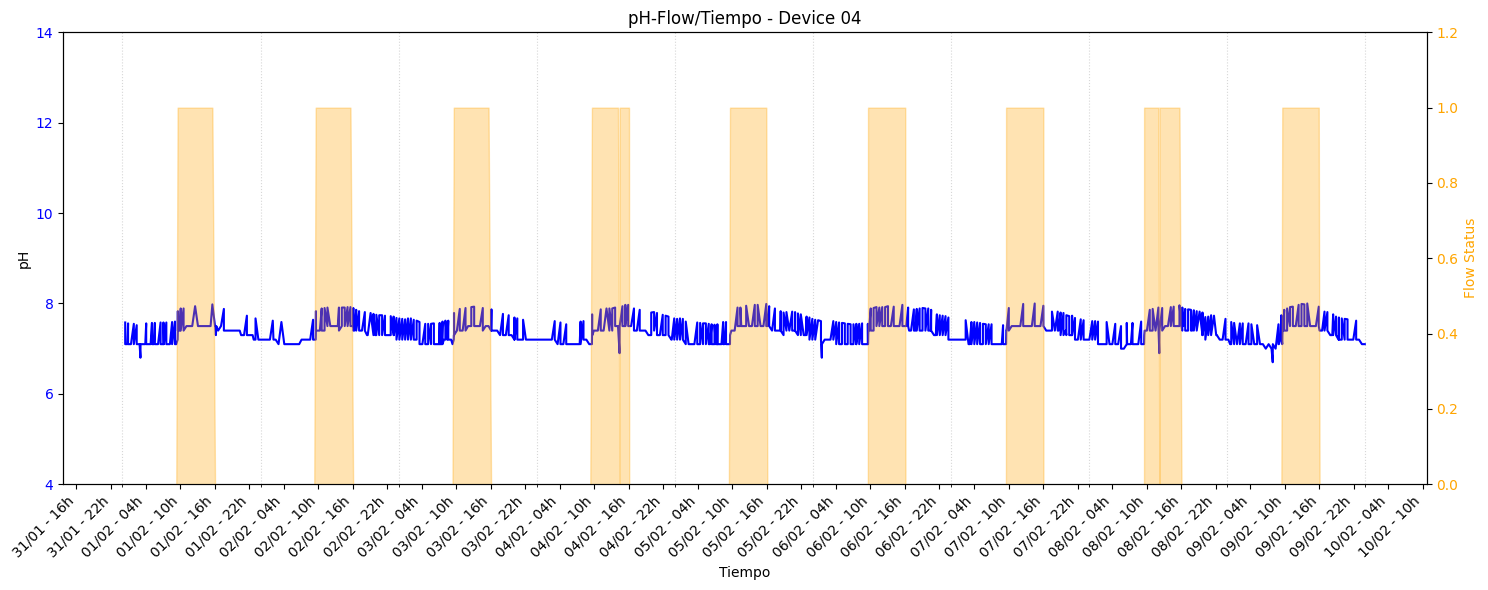

Número de activaciones: 233


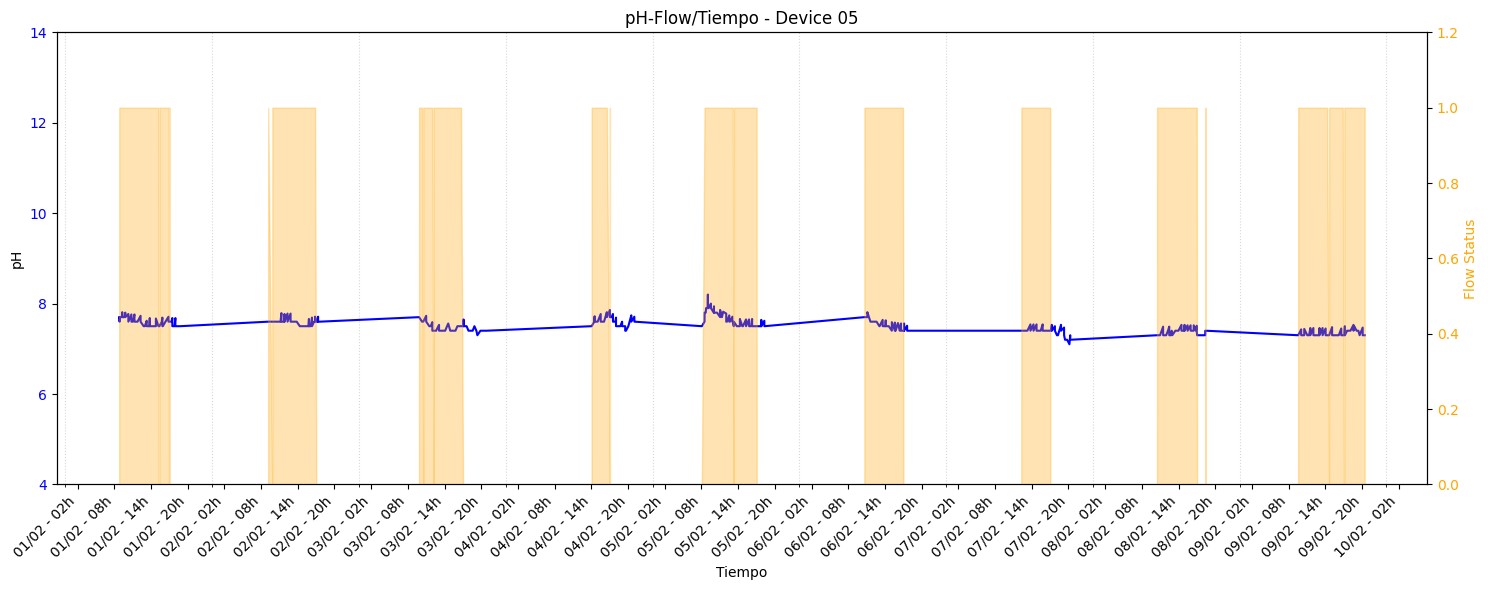

Número de activaciones: 324


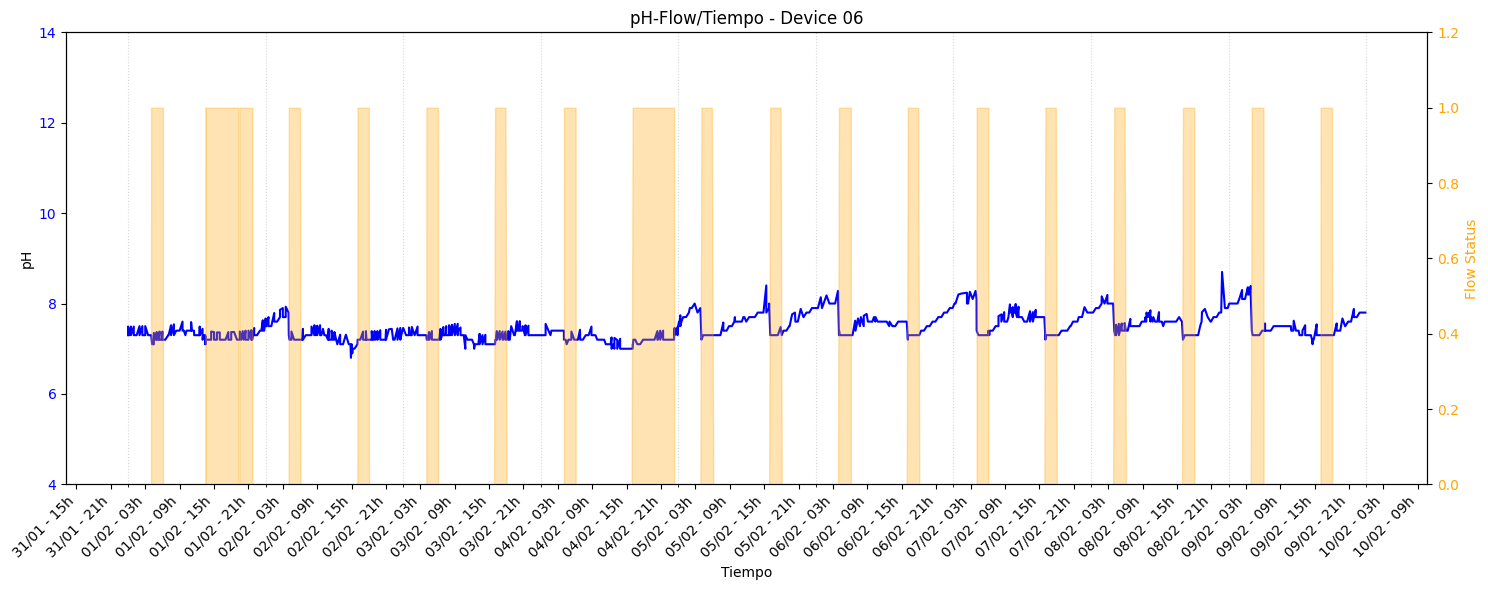

Número de activaciones: 239


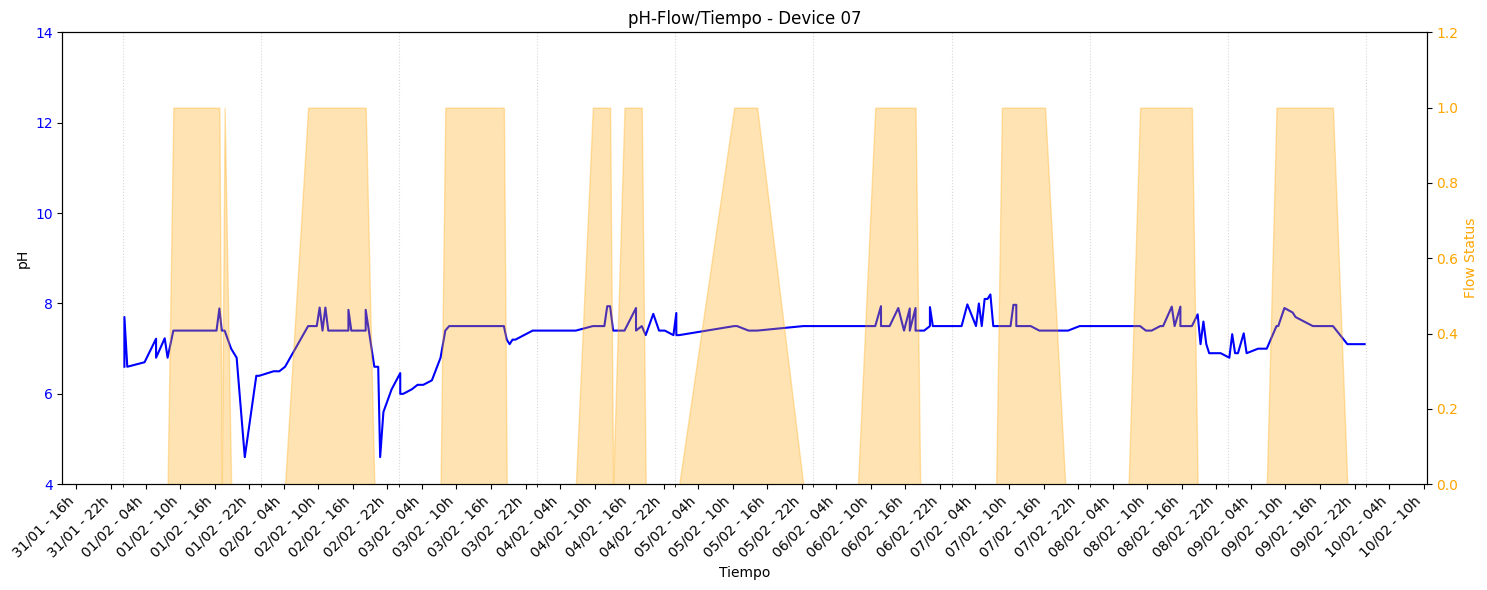

Número de activaciones: 100


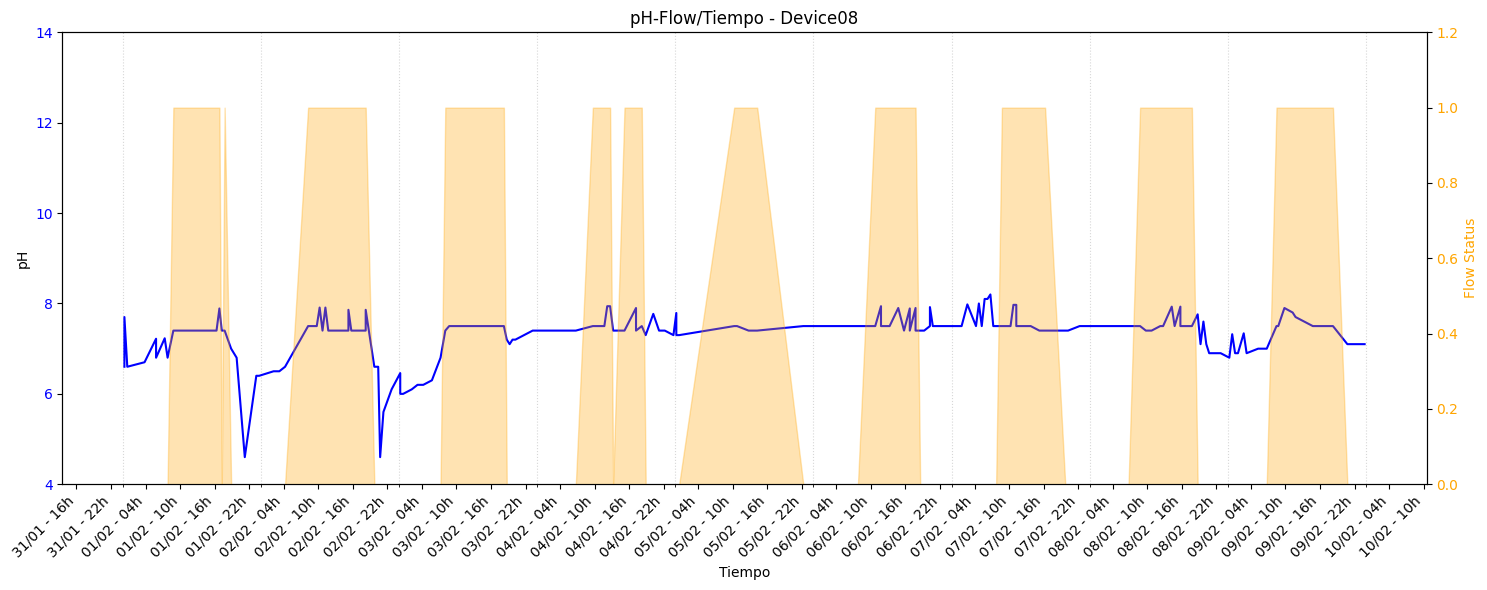

Número de activaciones: 100


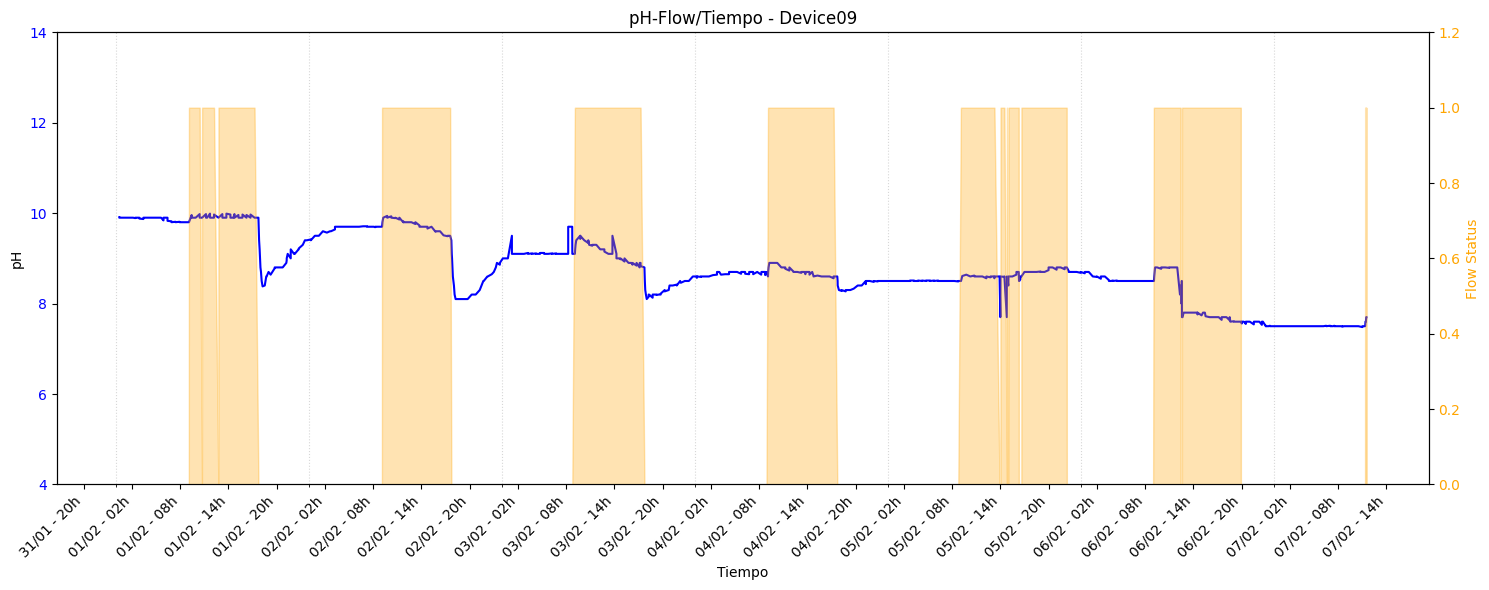

Número de activaciones: 261


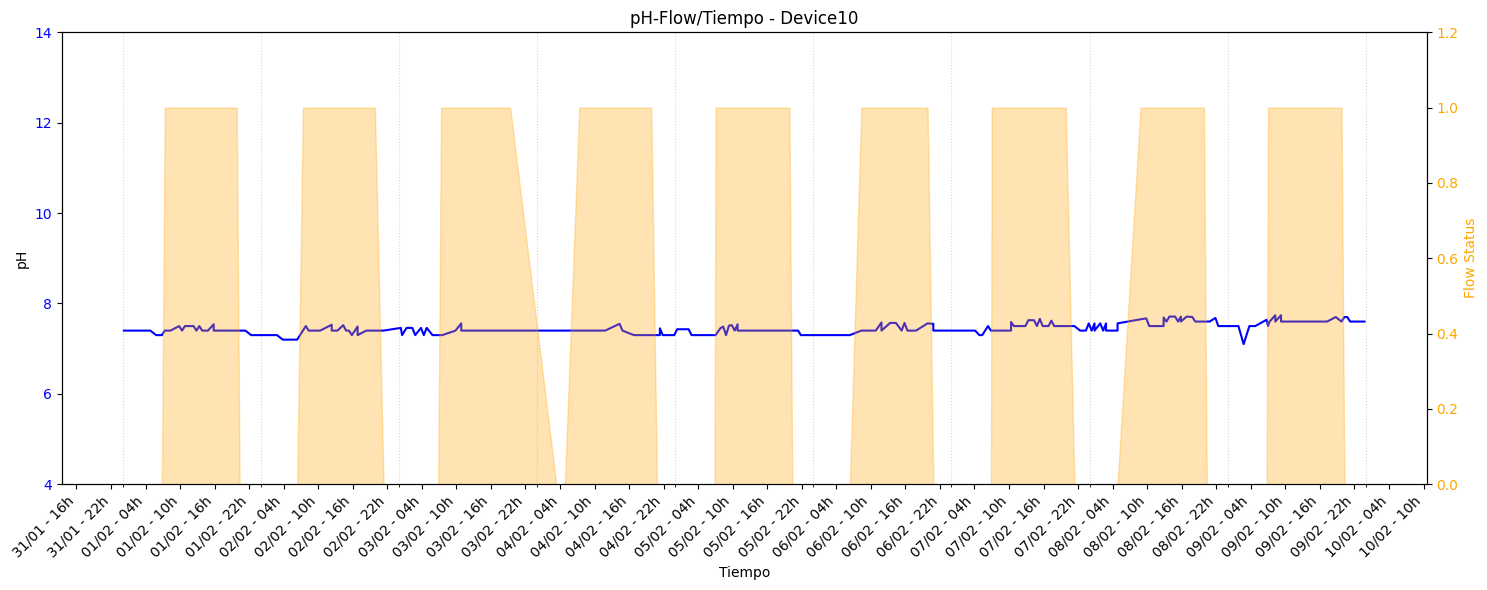

Número de activaciones: 154


In [18]:
for device in devices:
    # Filtrar datos para el dispositivo y rango de fechas específico
    df_device = df[(df['Device'] == device) & 
                   (df['Time'] >= '2024-02-01') & 
                   (df['Time'] <= '2024-02-10')]
    
    df_device = df_device.sort_values('Time')
    fig, ax1 = plt.subplots(figsize=(15, 6))

    color = 'BLUE'
    ax1.set_xlabel('Tiempo')
    ax1.set_ylabel('pH')
    ax1.plot(df_device['Time'], df_device['PH'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim(4, 14)
    
    ax2 = ax1.twinx()
    color = 'orange'
    ax2.set_ylabel('Flow Status', color=color)
    ax2.fill_between(df_device['Time'], 0, df_device['Flow status'], color=color, alpha=0.3)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0, 1.2)
    
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m - %Hh'))
    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=6))
    ax1.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    ax1.xaxis.set_minor_locator(mdates.DayLocator())
    ax1.grid(which='minor', axis='x', linestyle=':', alpha=0.5)
    
    plt.title(f'pH-Flow/Tiempo - {device}')
    plt.tight_layout()
    plt.show()
    print(f"Número de activaciones: {df_device['Flow status'].sum()}")

*Conclusiones de pH-Flow Vs Tiempo acotado:*
- Habria que estudiar porque devices como 02.2 no tienen data
- A simple vista el Device 02 y 09 son iguales
- Device 07 y 08 parecen tambien ser el mismo porque no puede ser que haya dos piscinas con las mismas lecturas exactas
- Exceptuando el comportamiento del device 01, el resto parecen tener ciclos de operacion de unas 8horas al dia donde todos ocurren en un periodo en particular del dia excepto en el caso del device 06 parece tener dos ciclos diarios.
- Cuando el Flow es 0 se ven comportamientos que se salen de los valores tipicos del pH, esto se puede deber a que la lectura se sigue realizando en un agua estancada en el clorificador y podria afectar a sus lecturas reales.

Conociendo todos estos datos se tomaran futuras decisiones para el procesamiento de datos

#### Ciclos de Funcionamiento

- Para comprobar el comportamiento del sistema, vamos a crear una funcion para conocer cuantos dias realmente el sistema ha estado operando, y que media de horas en ese periodo de funcionamiento. Y establecemos una condicion de que los días activos son aquellos que hayan funcionado al menos una hora en total. 

In [19]:
# Funcion para calcular los dias activos y el promedio diario de funcionamiento
def day_activation(data_dev):
    data_dev = data_dev.sort_values('Time')
    daily_act = {}
    prev_row = None
    
    for _, row in data_dev.iterrows():
        day = row['Time'].date()
        if day not in daily_act:
            daily_act[day] = timedelta()
        
        if prev_row is not None:
            if prev_row['Flow status'] == 1:
                act_time = row['Time'] - prev_row['Time']
                daily_act[day] += act_time
        
        prev_row = row
    
    return daily_act

results = []

for device in devices:
    data_dev = df[df['Device'] == device]
    
    daily_acts = day_activation(data_dev)
    
    # Condicion - Filtrar días con activación de al menos 1 hora
    active_days = {day: time for day, time in daily_acts.items() if time.total_seconds() >= 3600}
    
    # Tiempo total de activación
    total_act_time = sum(active_days.values(), timedelta())
    
    # Calcular número de ciclos (cambios de 0 a 1)
    cycles = (data_dev['Flow status'].diff() == 1).sum()
    
    # Contar días
    active_day_count = len(active_days)
    
    # Promedio diario 
    if active_day_count > 0:
        avg_daily_hours = total_act_time.total_seconds() / (3600 * active_day_count)
    else:
        avg_daily_hours = 0
    
    # Almacenamos
    results.append({
        'Dispositivo': device,
        'Total activo (h)': total_act_time.total_seconds() / 3600,
        'Numero de ciclos': cycles,
        'Dias activos': active_day_count,
        'Media diaria (h)': avg_daily_hours})

results_df = pd.DataFrame(results)
results_df = results_df.round(2).to_string()
print("Resultados del análisis de activación por dispositivo:")
print(results_df)

#results_df.to_csv('Media_diaria_funcionamiento.csv', index=False)

Resultados del análisis de activación por dispositivo:
    Dispositivo  Total activo (h)  Numero de ciclos  Dias activos  Media diaria (h)
0     Device 01           1607.09               296           148             10.86
1     Device 02            177.74                57            20              8.89
2   Device 02.2            657.32                33             4            164.33
3     Device 03           1175.57               305           165              7.12
4     Device 04           1189.59               337           183              6.50
5     Device 05           1679.09               289           101             16.62
6     Device 06            796.18               545           181              4.40
7     Device 07           1801.55               296           183              9.84
8      Device08           1801.55               296           183              9.84
9      Device09            177.74                57            20              8.89
10     Device10      

### Tratamiento de Datos - Toma de decisiones
- Como hemos visto en graficas anteriores y en resumenes de datos el device 2 y 9 son el mismo, y el 07 y 08 tambien parecen coincidir, a partir de ahora nos quedaremos unicamente con uno de cada uno para hacer mas ameno el caso.
- Tambien se decide hacer un pretatamiento para todo el df como en el device 1 y eliminar los datos duplicados
- Eliminamos todas las filas donde el Flow es 0 y la bomba esta apagada porque son datos corruptos.

In [20]:
#Elimiar todas las columnas del Dataset , de todos los devide donde la bomba no estaba activa osea donde el Flow Status es 0.
#Filas donde Flow status es 1
df = df[df['Flow status'] == 1]

print(f"Datos después de filtrar por 'Flow status' igual a 1: {df.shape}")
df.head(2)

#Cuantos duplicados totales
duplicates = df.duplicated().sum()
print(f"Número de filas duplicadas: {duplicates}")
#Los Eliminamos 
df.drop_duplicates(inplace=True)
duplicates = df.duplicated().sum()
print(f"Número de filas duplicadas: {duplicates}")

Datos después de filtrar por 'Flow status' igual a 1: (30206, 7)
Número de filas duplicadas: 132
Número de filas duplicadas: 0


In [21]:
df = df[df['Device'] != 'Device09']
df = df[df['Device'] != 'Device08']
df = df[df['Device'] != 'Device 02.2']
devices = df['Device'].unique()
print(f' Losd dispositivos a analizar a partir de ahora son: {devices}')

 Losd dispositivos a analizar a partir de ahora son: ['Device 01' 'Device 02' 'Device 03' 'Device 04' 'Device 05' 'Device 06'
 'Device 07' 'Device10']


## Deteccion de OUTLIERS

| Parámetro        | Valores Estándar | Mínimo Peligroso  | Máximo Peligroso  |
|----------------- |------------------|-------------------|-------------------|
| pH               | 7.2 - 7.6        | < 6.8             | > 8.0             |
| ORP (mV)         | 625 - 750        | < 600             | > 900             |
| Salinidad (ppm)  | 2700 - 3400      | < 2000            | > 6000            |

- pH: Valores fuera del rango 6.8 - 8.0 pueden causar irritación en piel y ojos, además de afectar la eficacia de los desinfectantes.
- ORP: Por debajo de 600 mV, la desinfección puede ser inadecuada. Por encima de 900 mV, puede haber un exceso de desinfectantes que podría ser irritante.
- Salinidad: Niveles muy bajos reducen la eficacia del sistema de cloración salina, mientras que niveles muy altos pueden causar corrosión en equipos metálicos y ser incómodos para los nadadores. Aunque este dato es mucho menos relevante. 

### Device 1: Tratamiento de datos para un solo Device

Vamos a ver con el device 1 como quedan los datos, habiendo eliminado las anomalias de -9999,
y los datos recogidos cuando el flow era 0, para el device 1. 

In [22]:
# Filtrar datos para el dispositivo 1
df_device1 = df[df['Device'] == 'Device 01']

# Método IQR para eliminar outliers
def outliers(df, columns):
    df_clean = df.copy()
    for column in columns:
        Q1 = df_clean[column].quantile(0.25)
        Q3 = df_clean[column].quantile(0.75)
        IQR = Q3 - Q1
        limiteQ1 = Q1 - 1.5 * IQR
        limiteQ3 = Q3 + 1.5 * IQR 
        df_clean = df_clean[(df_clean[column] >= limiteQ1) & (df_clean[column] <= limiteQ3)]
    return df_clean

# Llamar outliers
df_1_clean = outliers(df_device1, parameters)

print(f"Filas dataset original del Device 01: {len(df_device1)}")
print(f"Filas después de eliminar errores y valores fuera de rango: {len(df_device1)-len(df_1_clean) }") 
print(f"Filas después de eliminar outliers: {len(df_1_clean)}")
percent_kept = (len(df_1_clean) / len(df_device1)) * 100
print(f"\nPorcentaje de datos conservados: {percent_kept:.2f}%")

print("\nEstadísticas descriptivas de los datos limpios:")
print(df_1_clean[parameters].describe())

Filas dataset original del Device 01: 6270
Filas después de eliminar errores y valores fuera de rango: 1922
Filas después de eliminar outliers: 4348

Porcentaje de datos conservados: 69.35%

Estadísticas descriptivas de los datos limpios:
                PH          ORP     Salinity  Temperature
count  4348.000000  4348.000000  4348.000000  4348.000000
mean      7.521907   625.124885  5240.105566    25.014029
std       0.142721    78.580943   114.656188     3.345256
min       7.140000   381.000000  4950.000000    15.000000
25%       7.400000   570.000000  5174.000000    23.000000
50%       7.500000   637.000000  5256.000000    26.000000
75%       7.600000   683.000000  5310.000000    27.000000
max       7.890000   803.000000  5550.000000    31.000000


In [23]:
df_1_clean['PH'].describe()

count    4348.000000
mean        7.521907
std         0.142721
min         7.140000
25%         7.400000
50%         7.500000
75%         7.600000
max         7.890000
Name: PH, dtype: float64

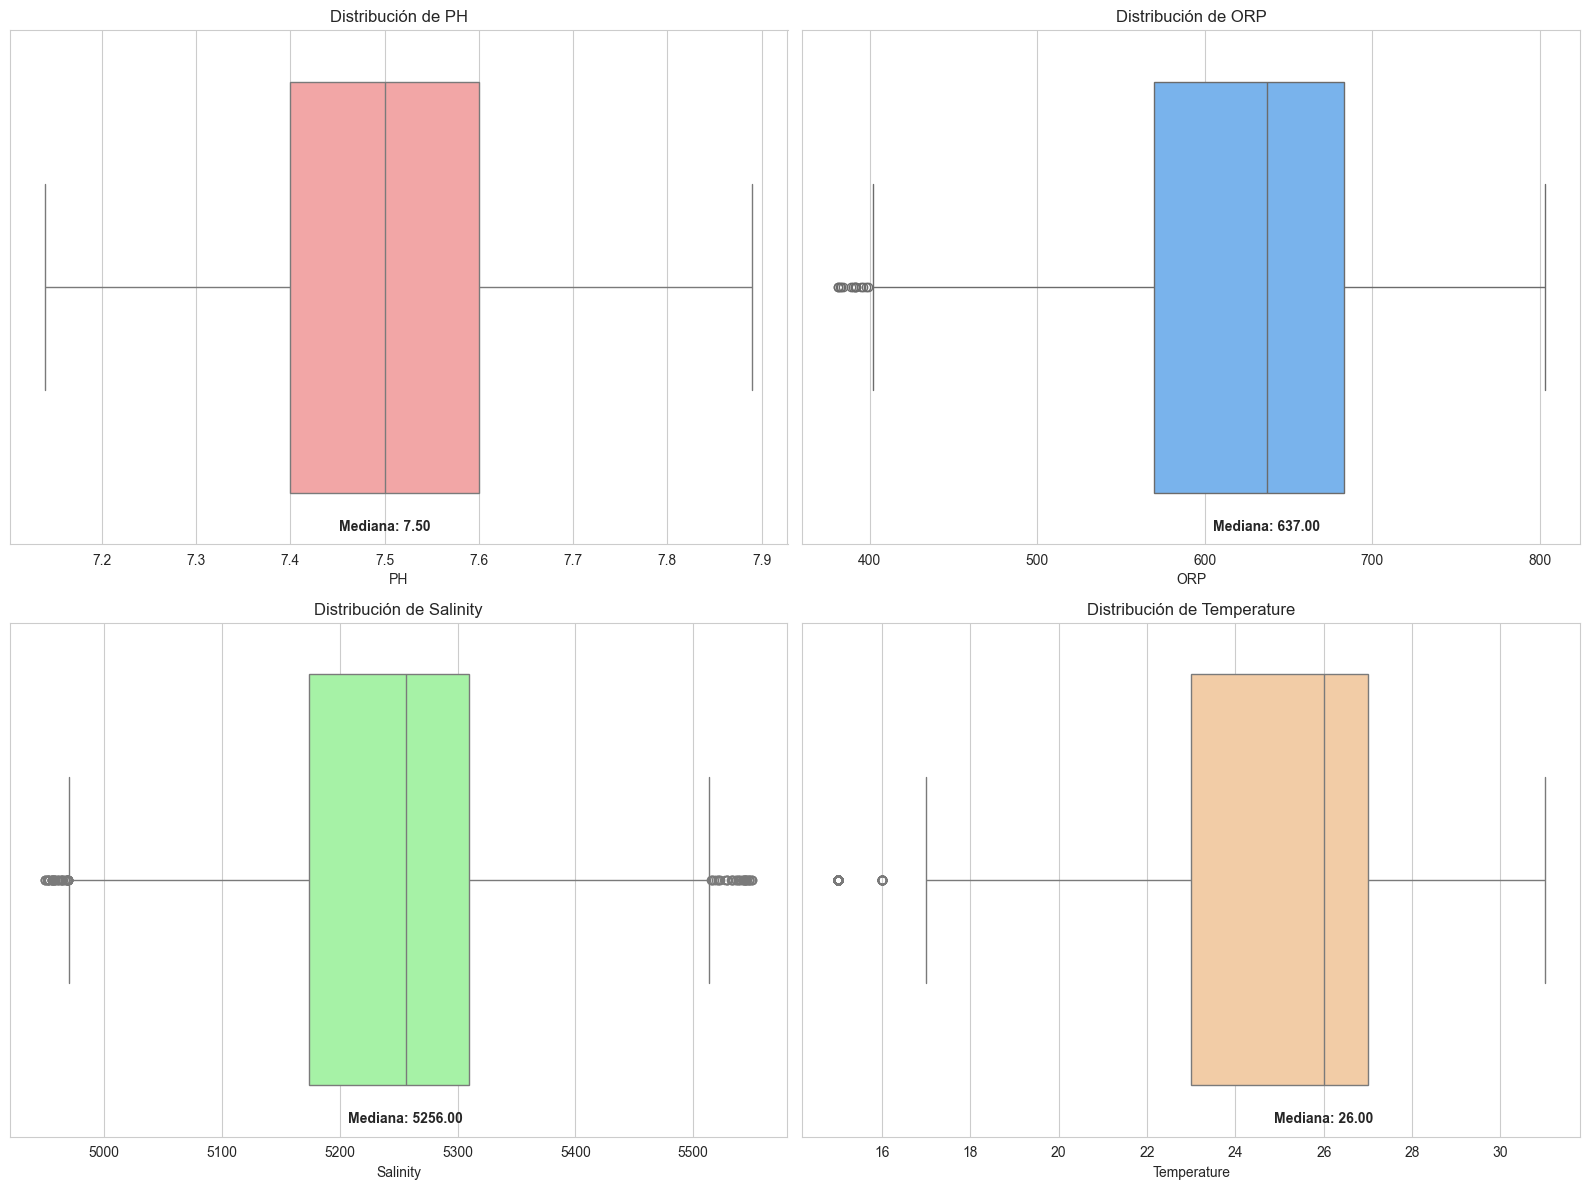

In [24]:
# DIagrama de cajas para ver la distribucion de los datos despues de la limpiexa
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

colores = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
for ax, parameter, color in zip(axes, parameters, colores):
    sns.boxplot(x=df_1_clean[parameter], ax=ax, color=color)
    ax.set_title(f'Distribución de {parameter}')
    ax.set_xlabel(parameter)
    median = df_1_clean[parameter].median()
    ax.text(median, 0.02, f'Mediana: {median:.2f}',
            horizontalalignment='center', verticalalignment='bottom',
            transform=ax.get_xaxis_transform(), fontweight='bold')

plt.tight_layout()
plt.show()

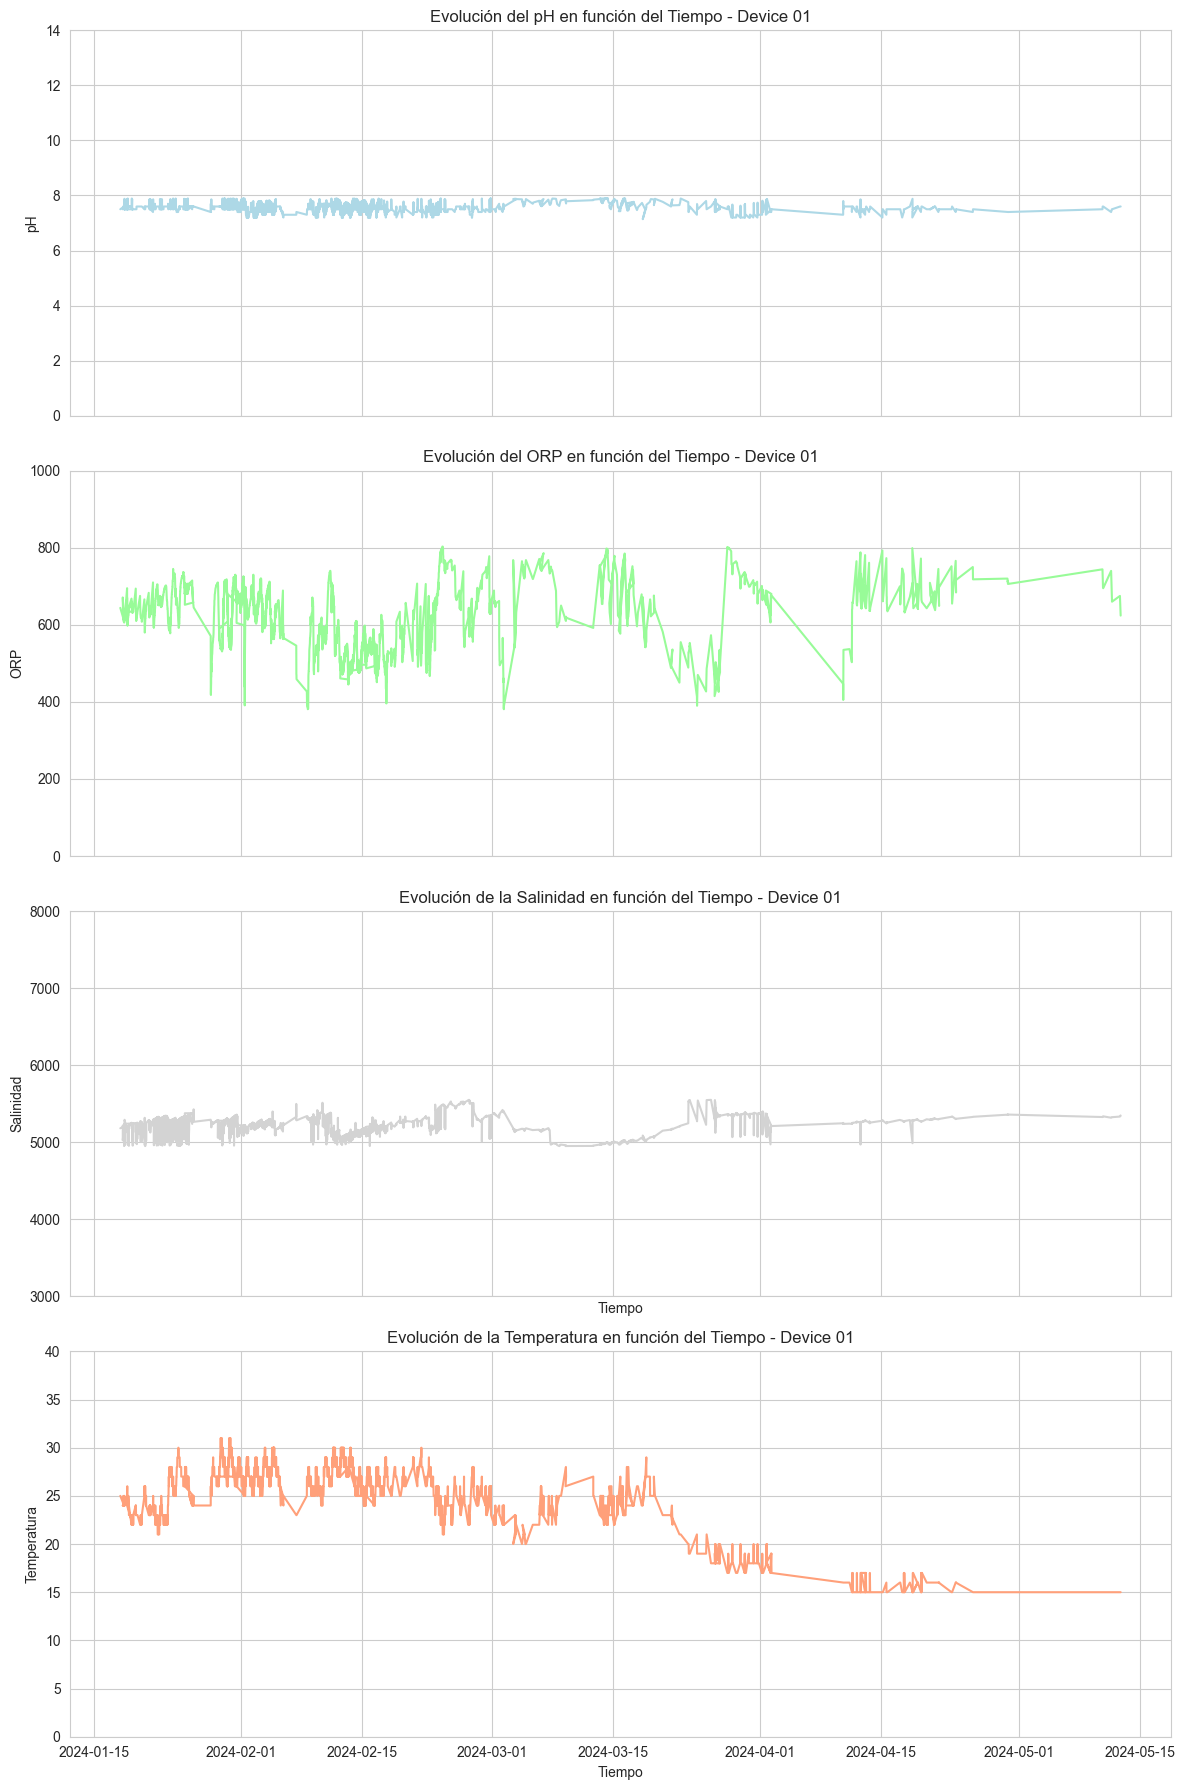

In [25]:
#Subplots
fig, axes = plt.subplots(4, 1, figsize=(12, 18), sharex=True)

# pH
axes[0].plot(df_1_clean['Time'], df_1_clean['PH'], linestyle='-', color='#ADD8E6')
axes[0].set_title('Evolución del pH en función del Tiempo - Device 01')
axes[0].set_ylim(0, 14)  
axes[0].set_ylabel('pH')
axes[0].grid(True)

# ORP
axes[1].plot(df_1_clean['Time'], df_1_clean['ORP'], linestyle='-', color='#98FB98')
axes[1].set_title('Evolución del ORP en función del Tiempo - Device 01')
axes[1].set_ylim(0, 1000) 
axes[1].set_ylabel('ORP')
axes[1].grid(True)

# Salinidad
axes[2].plot(df_1_clean['Time'], df_1_clean['Salinity'], linestyle='-', color='#D3D3D3')
axes[2].set_title('Evolución de la Salinidad en función del Tiempo - Device 01')
axes[2].set_ylim(3000, 8000)  
axes[2].set_ylabel('Salinidad')
axes[2].set_xlabel('Tiempo')
axes[2].grid(True)

# Temperatura
axes[3].plot(df_1_clean['Time'], df_1_clean['Temperature'], linestyle='-', color='#FFA07A')
axes[3].set_title('Evolución de la Temperatura en función del Tiempo - Device 01')
axes[3].set_ylim(0, 40)  
axes[3].set_ylabel('Temperatura')
axes[3].set_xlabel('Tiempo')
axes[3].grid(True)

plt.tight_layout()
plt.show()

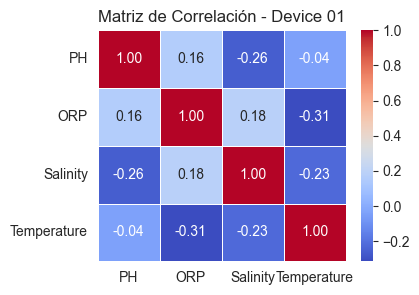

In [26]:
# Matriz de correlación
corr_matrix = df_1_clean[['PH', 'ORP', 'Salinity', 'Temperature']].corr()

# Crear la gráfica de la matriz de correlación
plt.figure(figsize=(4, 3))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Matriz de Correlación - Device 01')
plt.show()

- No encontramos en este caso ninguna correlacion extremadamente fuerte. Pero esto se puede deber a que el funcionamiento del sistema controla las variables, es decir, cuando el ORP es bajo empezamos a crear cloro y sube tambien la basicidad en el agua por lo que el sistema lo detecta y añade acido para corregir el pH. Para conocer realmente las correlaciones mas ademante se cogeran espacios temporales mas cortos y vermemos si encontramos mejores patrones de comportamiento


#### Tratamiento de datos de Todos los Device:
Repetiremos el mismo proceso anterior pero para todos los dispositivos. Recordemos que cada dispositivo se debe tratar de manera individual dadas sus condiciones, donde se tiene una localizacion y condiciones climaticas unicas, unos set points personalizados y unos tamaños diferentes. 

Datos limpios para Device 01 guardados en datos_limpios_Device 01.csv

Estadísticas Device 01:
                PH          ORP     Salinity  Temperature
count  4348.000000  4348.000000  4348.000000  4348.000000
mean      7.521907   625.124885  5240.105566    25.014029
std       0.142721    78.580943   114.656188     3.345256
min       7.140000   381.000000  4950.000000    15.000000
25%       7.400000   570.000000  5174.000000    23.000000
50%       7.500000   637.000000  5256.000000    26.000000
75%       7.600000   683.000000  5310.000000    27.000000
max       7.890000   803.000000  5550.000000    31.000000
Porcentaje de datos conservados para Device 01: 69.35%
Imagen guardada como ParametrosVSTiempo_Device 01.png


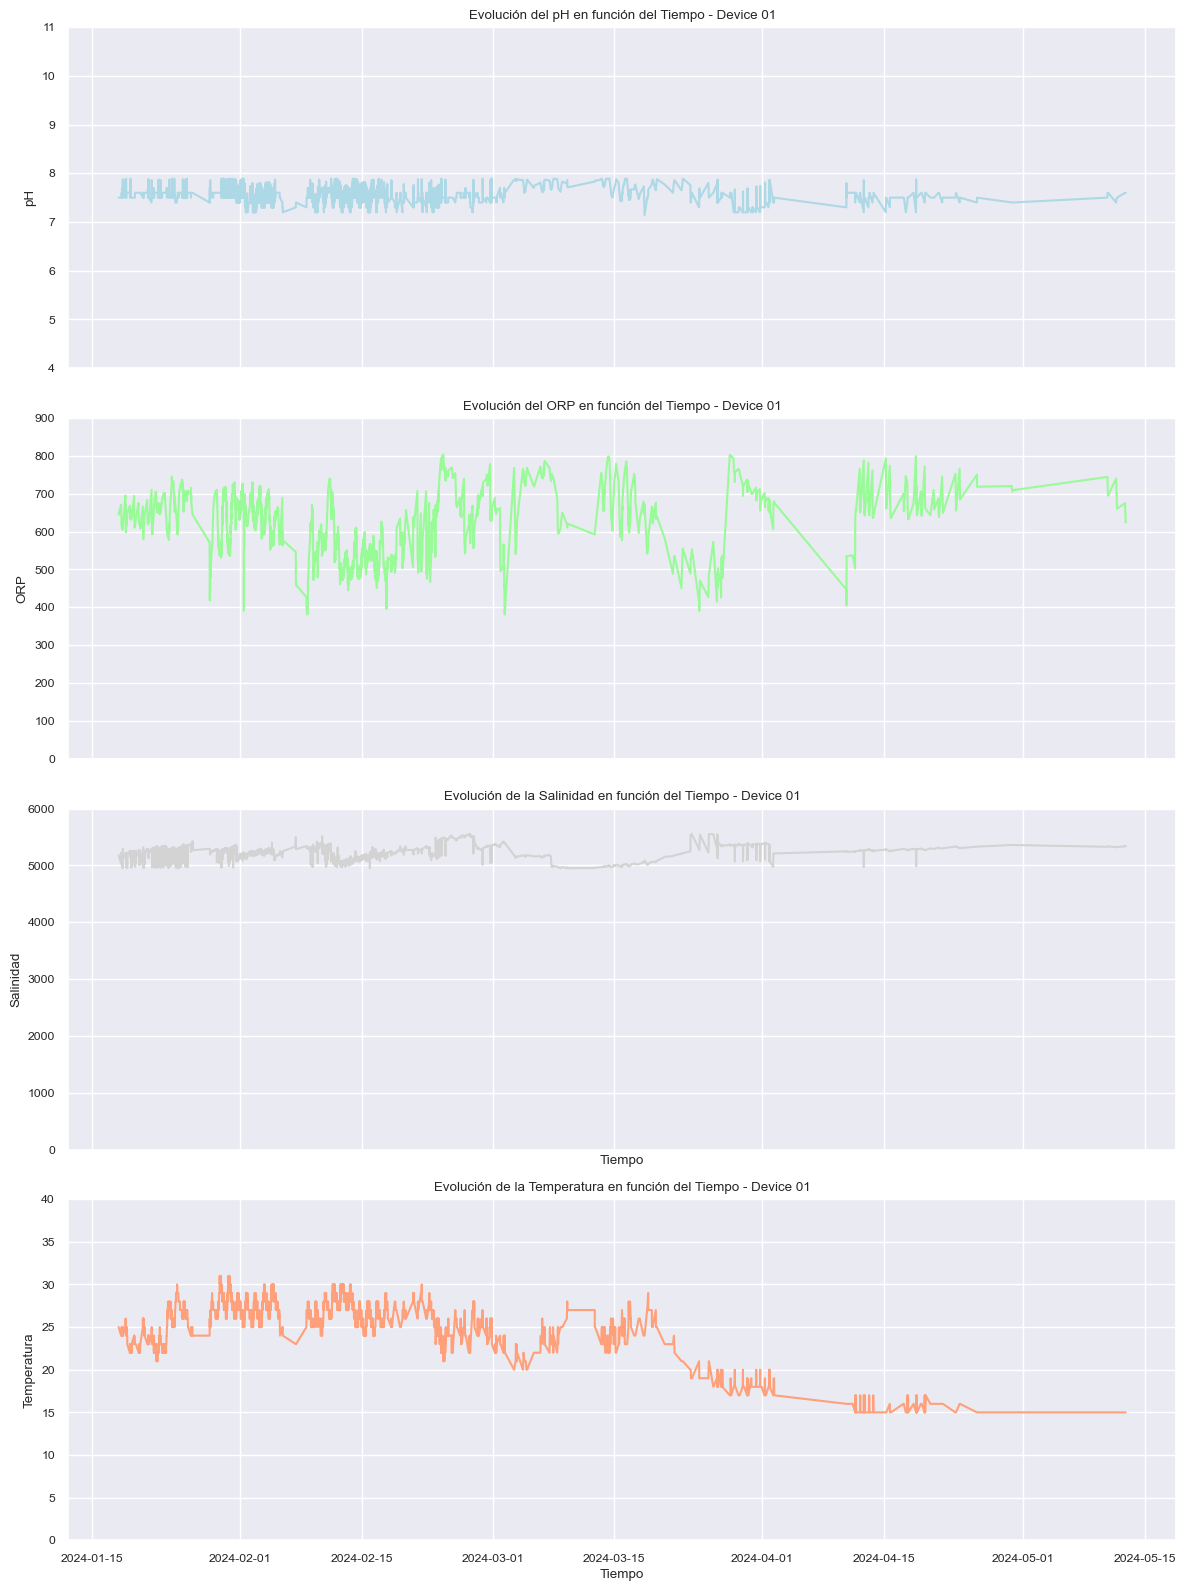

Datos limpios para Device 02 guardados en datos_limpios_Device 02.csv

Estadísticas Device 02:
               PH         ORP     Salinity  Temperature
count  602.000000  602.000000   602.000000    602.00000
mean     9.811080  283.189369  5253.991694     30.23588
std      0.211156   62.725539   408.912768      1.51888
min      8.900000  178.000000  4478.000000     26.00000
25%      9.800000  242.000000  4732.000000     29.00000
50%      9.900000  262.000000  5502.500000     30.00000
75%      9.900000  317.000000  5564.000000     31.00000
max     10.000000  436.000000  5783.000000     34.00000
Porcentaje de datos conservados para Device 02: 80.16%
Imagen guardada como ParametrosVSTiempo_Device 02.png


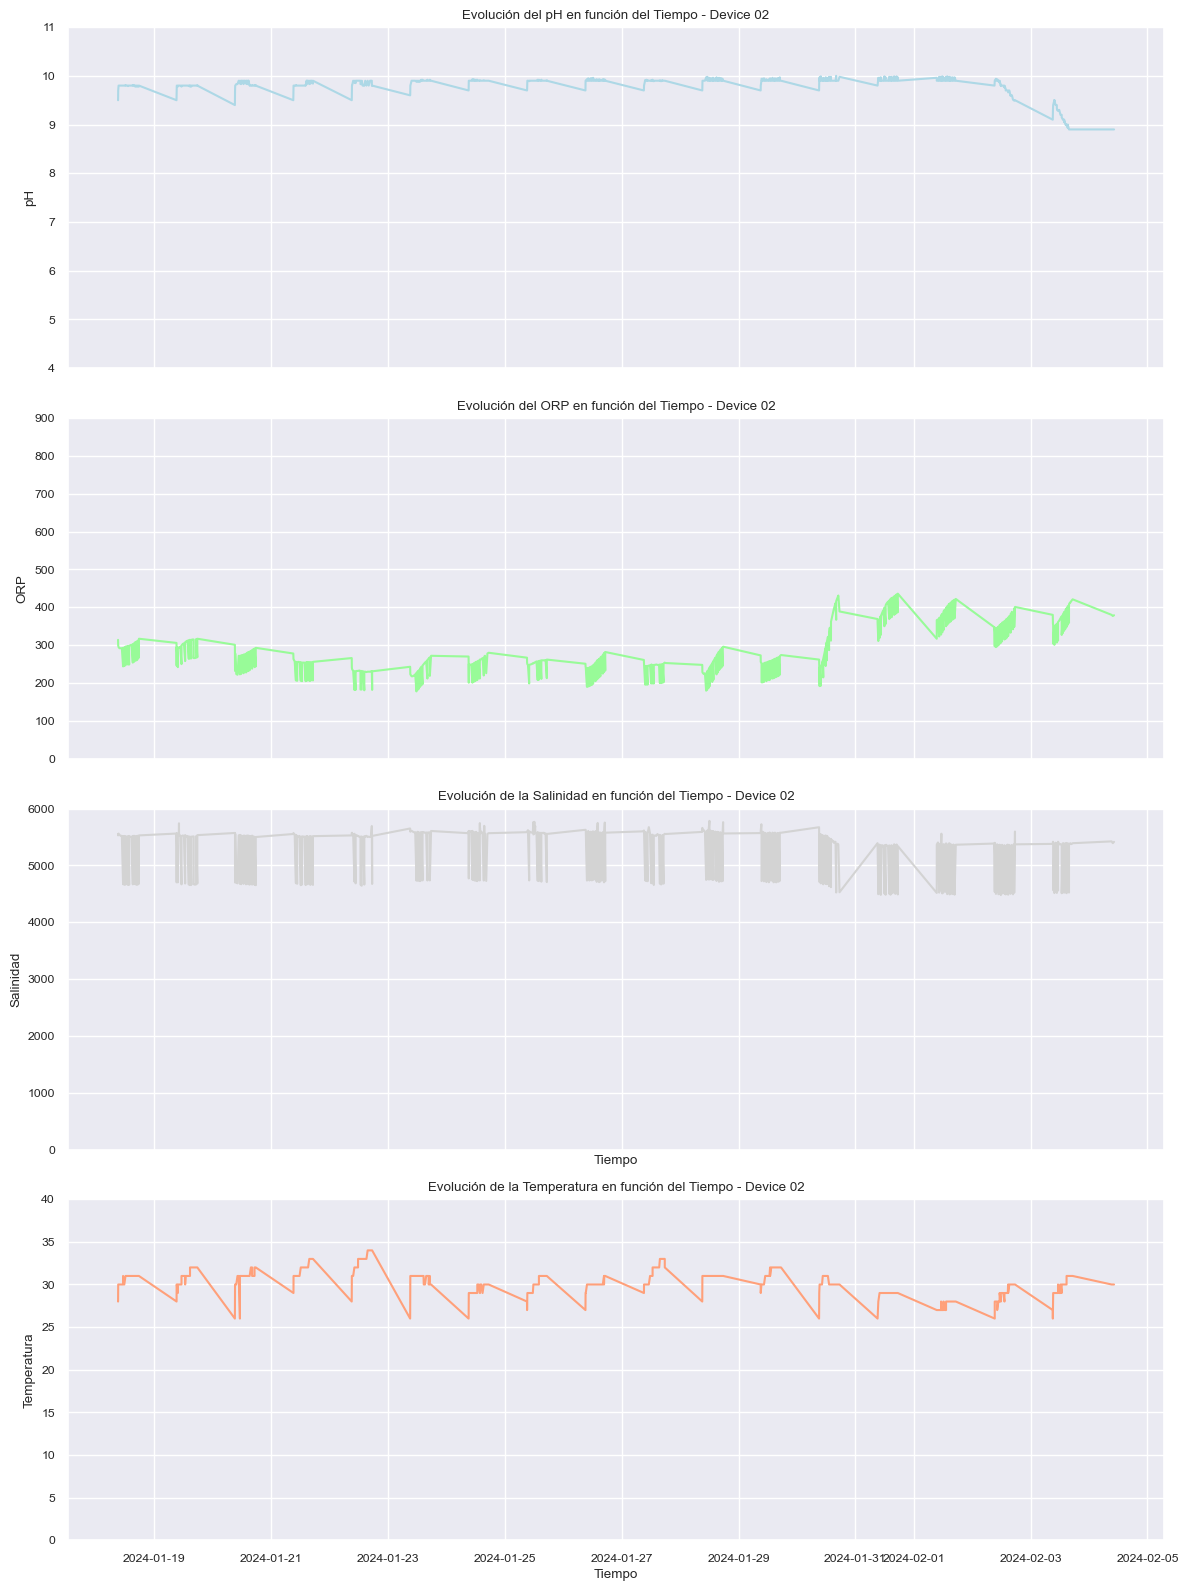

Datos limpios para Device 03 guardados en datos_limpios_Device 03.csv

Estadísticas Device 03:
                PH          ORP     Salinity  Temperature
count  3964.000000  3964.000000  3964.000000  3964.000000
mean      7.352417   563.127901  5622.994702    22.932139
std       0.080702    37.761520   337.933074     3.910775
min       7.150000   454.000000  4470.000000    14.000000
25%       7.300000   538.000000  5549.000000    19.000000
50%       7.400000   560.000000  5707.000000    24.000000
75%       7.400000   590.000000  5836.000000    26.000000
max       7.530000   687.000000  6589.000000    35.000000
Porcentaje de datos conservados para Device 03: 64.33%
Imagen guardada como ParametrosVSTiempo_Device 03.png


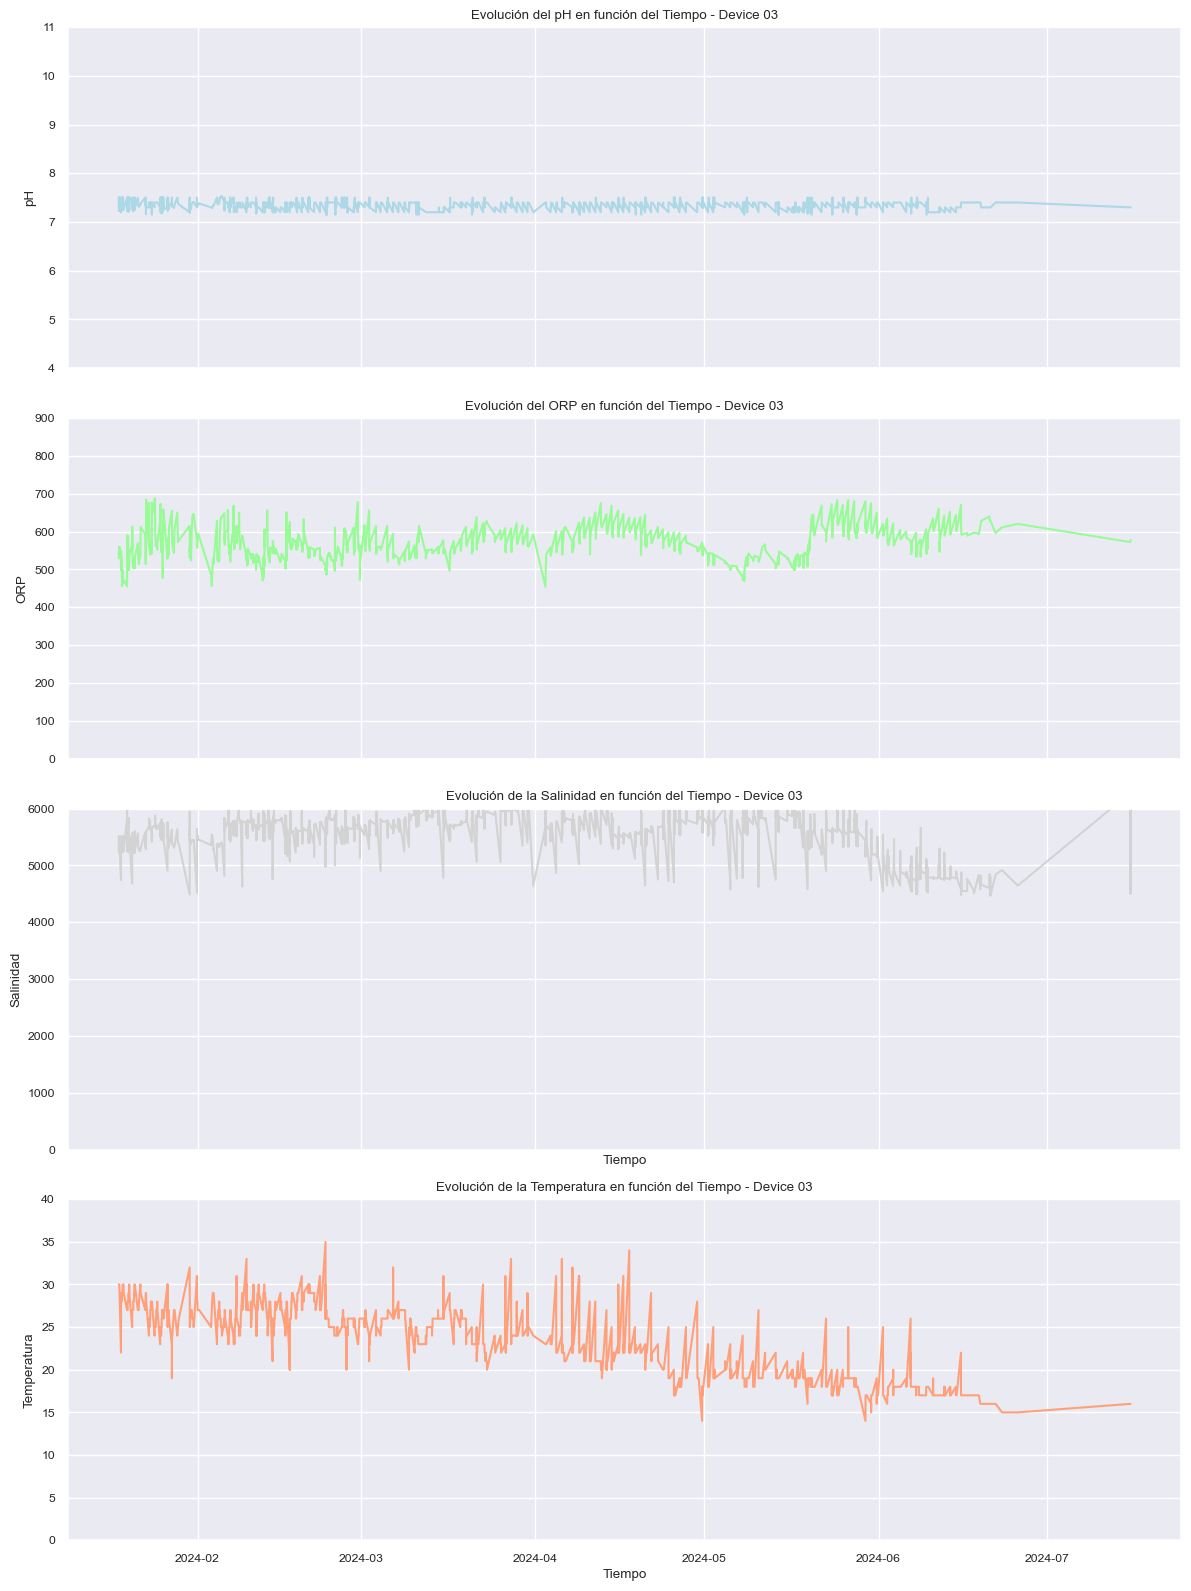

Datos limpios para Device 04 guardados en datos_limpios_Device 04.csv

Estadísticas Device 04:
                PH          ORP     Salinity  Temperature
count  4294.000000  4294.000000  4294.000000  4294.000000
mean      7.619506   659.754541  3845.663484    25.695622
std       0.242965    23.637339   463.643672     1.471935
min       7.000000   593.000000  2905.000000    22.000000
25%       7.500000   643.000000  3480.000000    25.000000
50%       7.500000   660.000000  3822.000000    26.000000
75%       7.810000   677.000000  4218.000000    27.000000
max       8.330000   727.000000  4991.000000    29.000000
Porcentaje de datos conservados para Device 04: 89.18%
Imagen guardada como ParametrosVSTiempo_Device 04.png


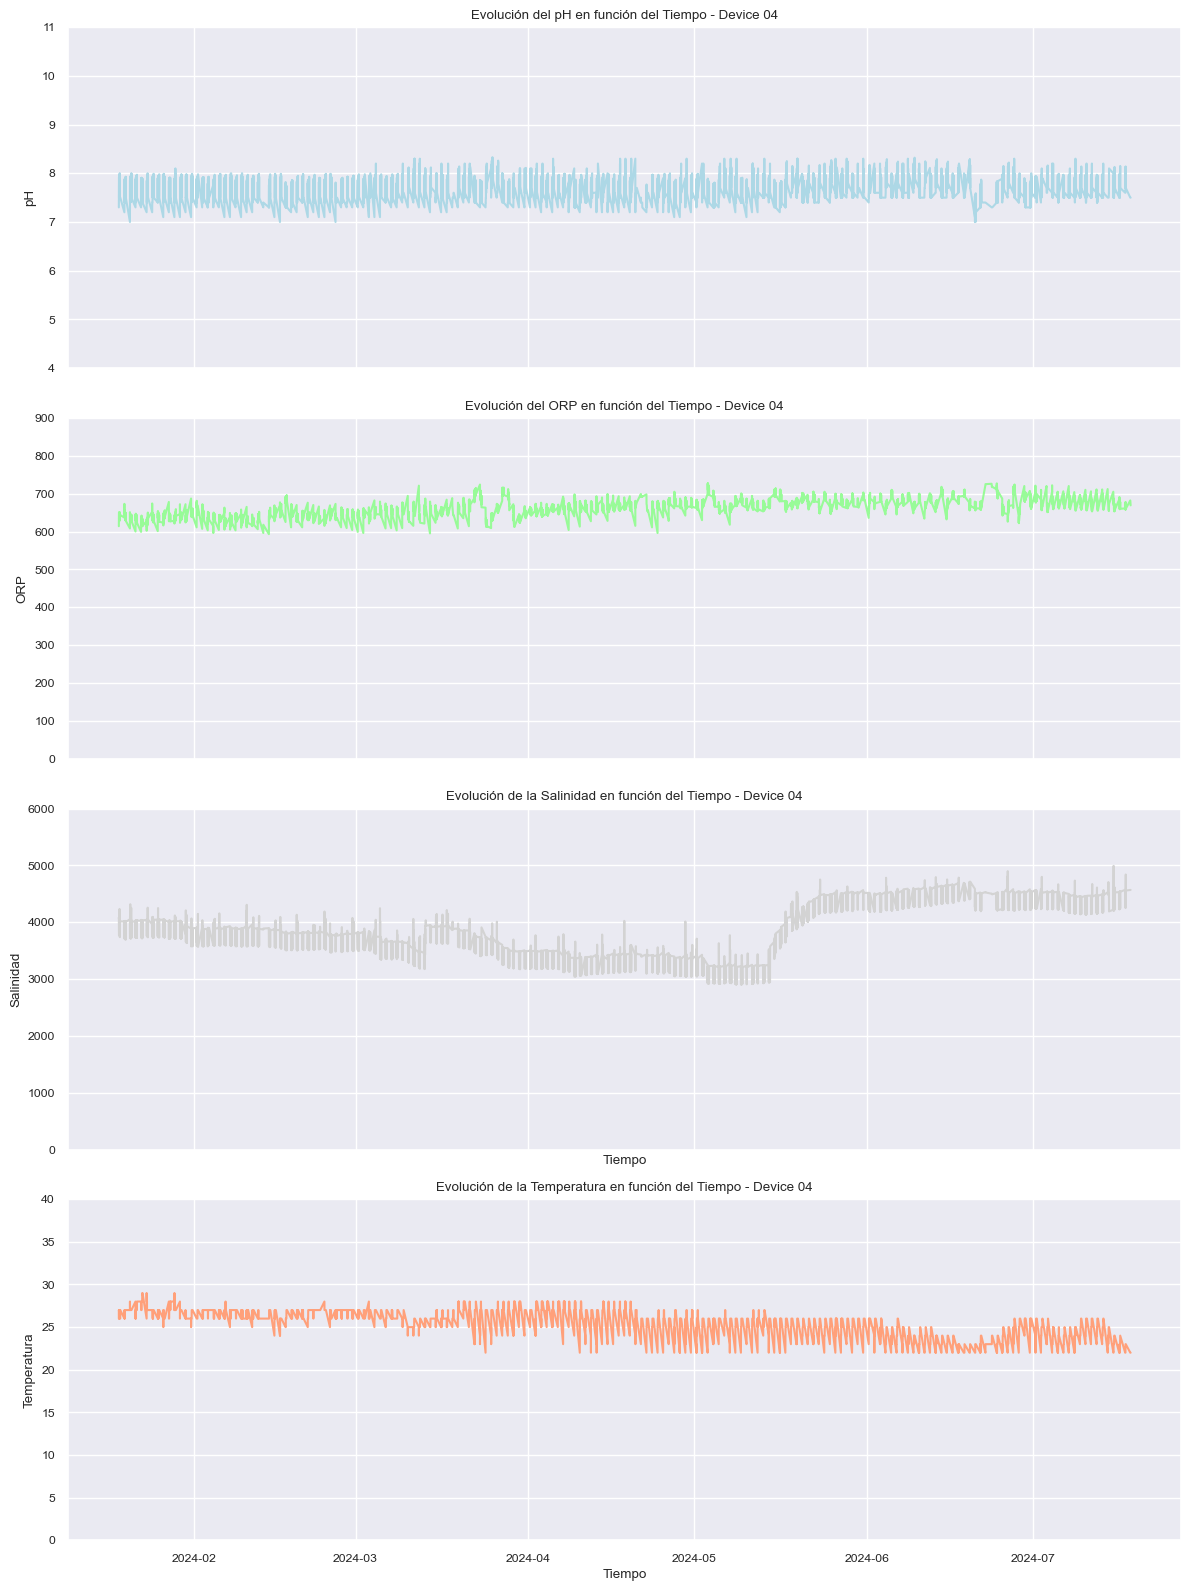

Datos limpios para Device 05 guardados en datos_limpios_Device 05.csv

Estadísticas Device 05:
                PH          ORP     Salinity  Temperature
count  1735.000000  1735.000000  1735.000000  1735.000000
mean      7.441718   676.954467  4016.677810    24.669164
std       0.223197    26.673551    89.837836     5.431449
min       6.900000   586.000000  3796.000000    11.000000
25%       7.300000   652.000000  3997.000000    23.000000
50%       7.400000   678.000000  4051.000000    26.000000
75%       7.600000   694.000000  4076.000000    28.000000
max       8.000000   754.000000  4238.000000    34.000000
Porcentaje de datos conservados para Device 05: 78.83%
Imagen guardada como ParametrosVSTiempo_Device 05.png


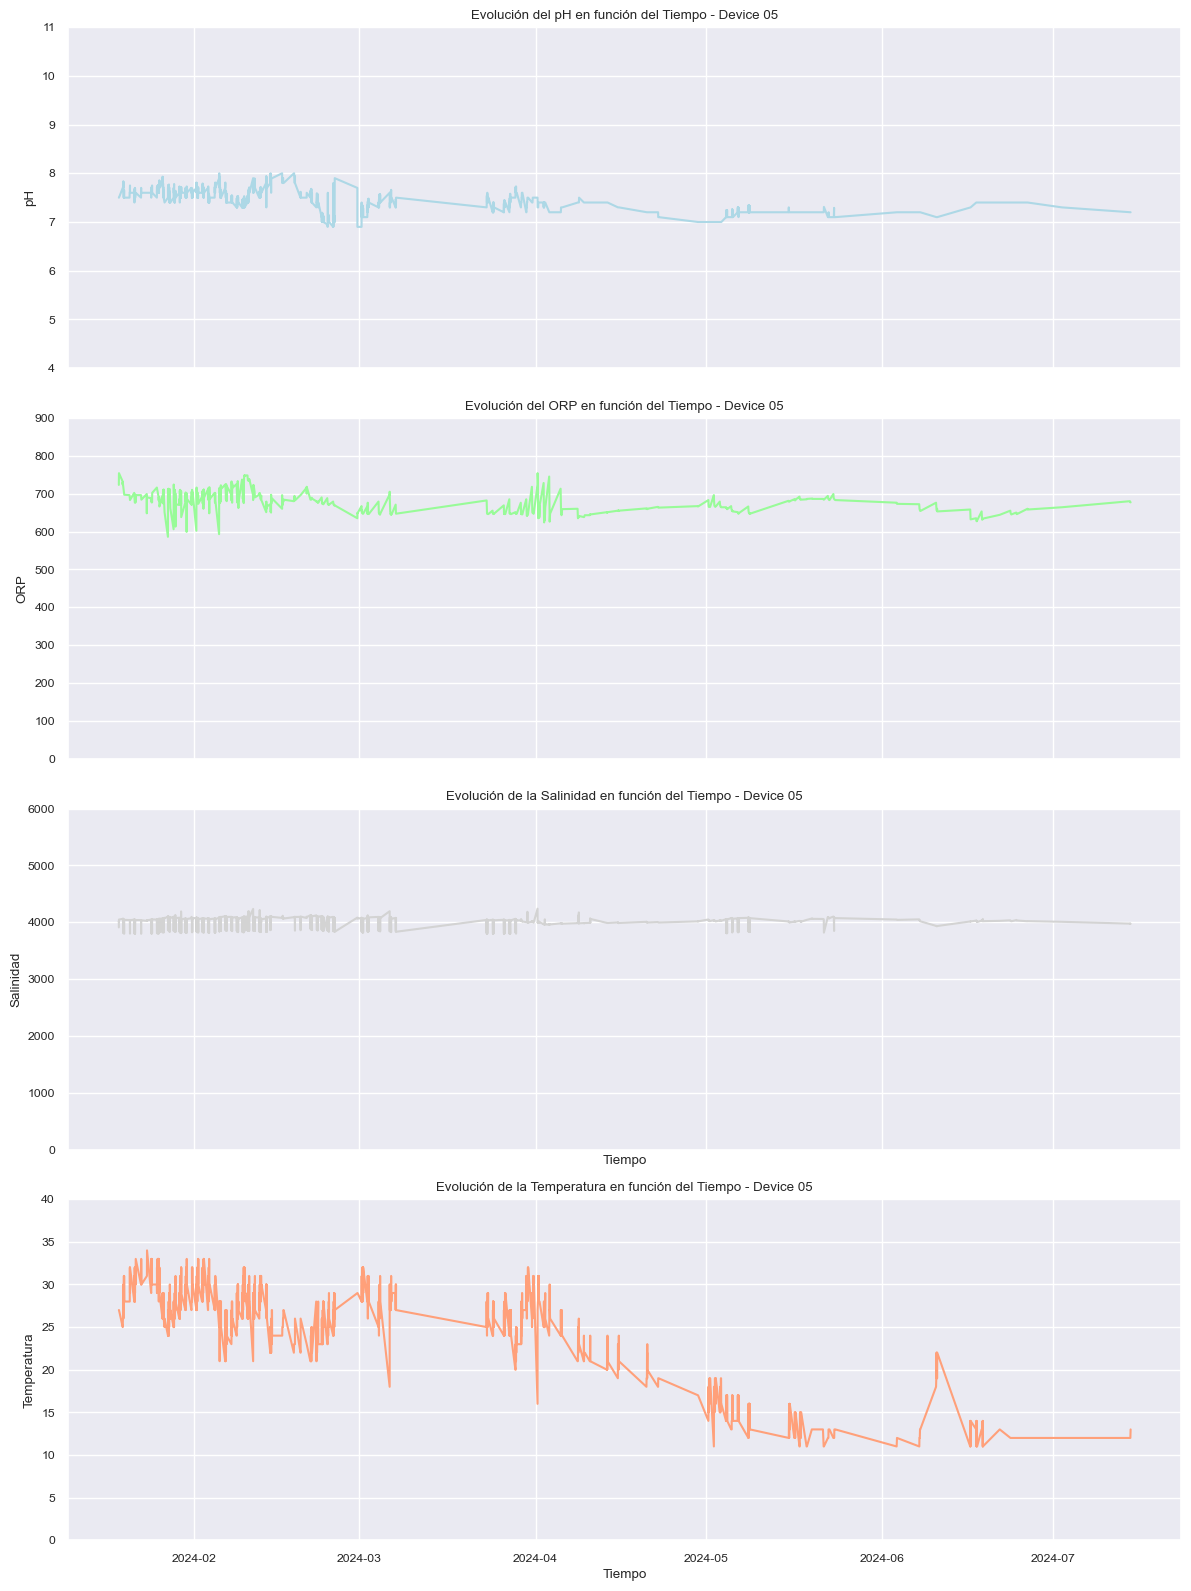

Datos limpios para Device 06 guardados en datos_limpios_Device 06.csv

Estadísticas Device 06:
                PH          ORP     Salinity  Temperature
count  2953.000000  2953.000000  2953.000000  2953.000000
mean      7.350003   640.447342  3689.121233    23.251609
std       0.092935    58.121579   160.043243     8.929756
min       7.200000   468.000000  3342.000000     1.000000
25%       7.300000   600.000000  3528.000000    16.000000
50%       7.400000   649.000000  3719.000000    27.000000
75%       7.400000   678.000000  3819.000000    31.000000
max       7.550000   803.000000  4228.000000    42.000000
Porcentaje de datos conservados para Device 06: 81.02%
Imagen guardada como ParametrosVSTiempo_Device 06.png


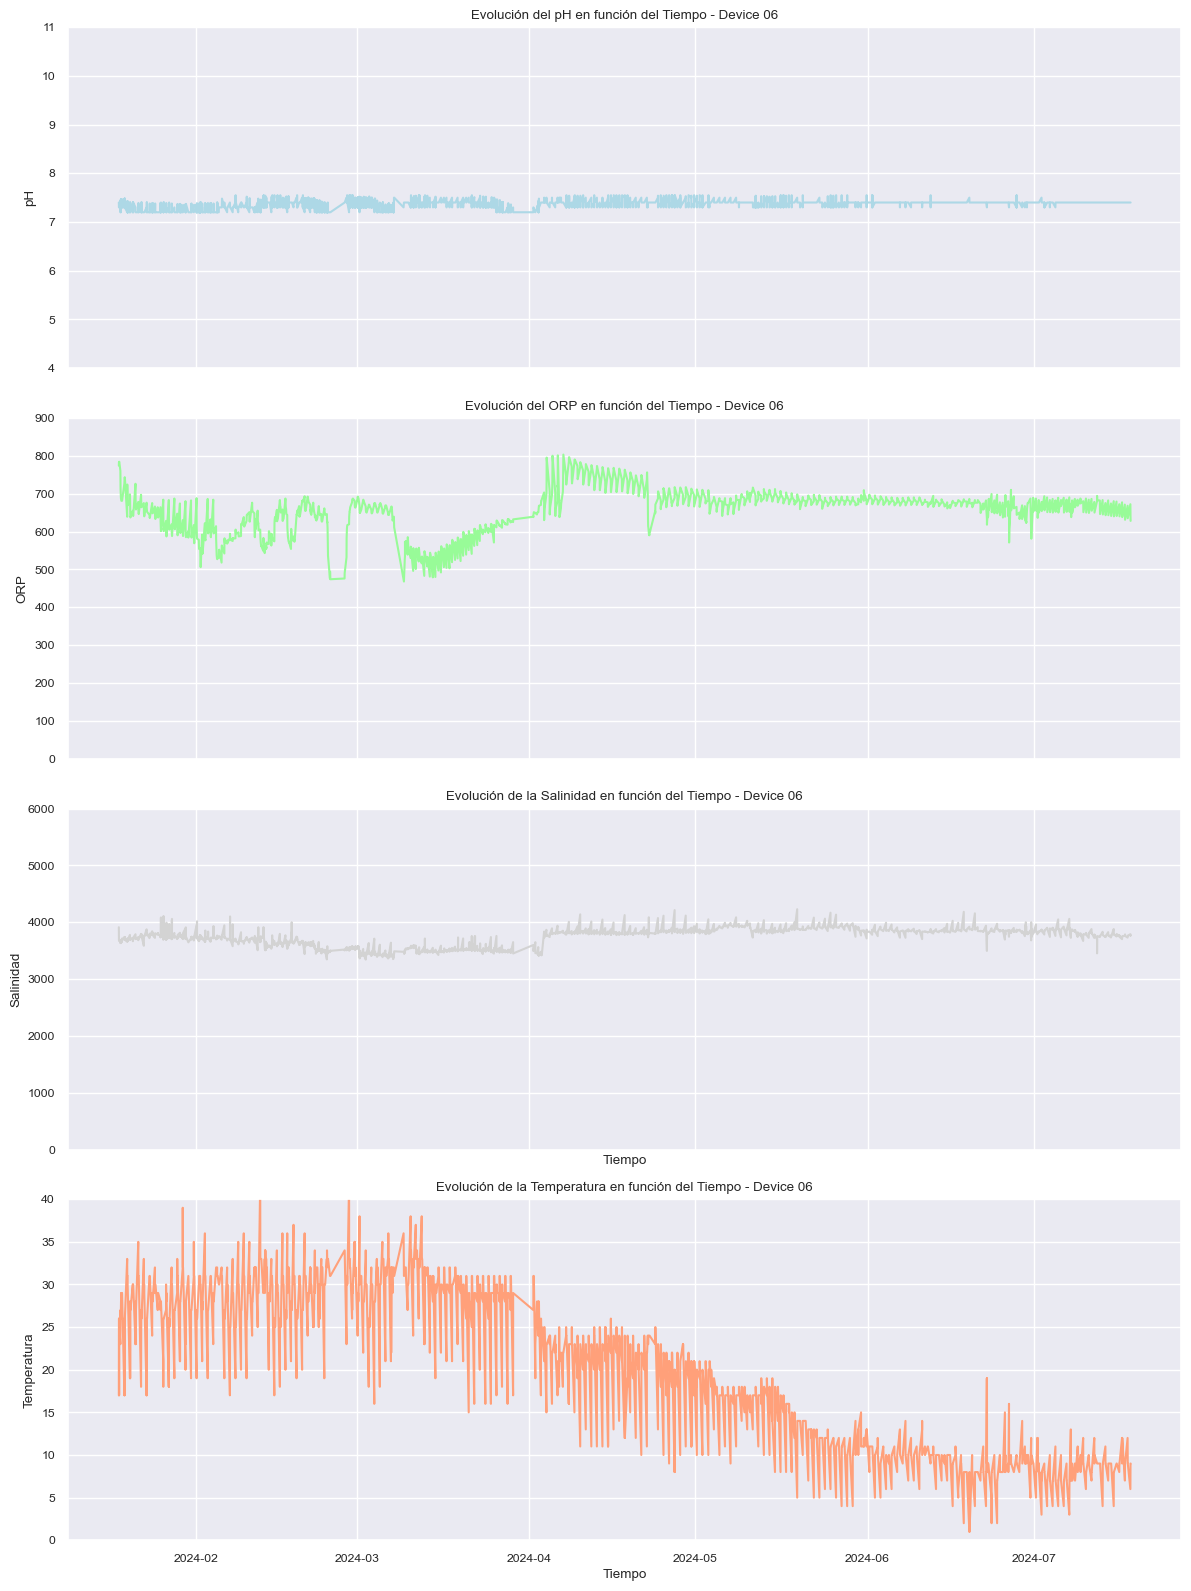

Datos limpios para Device 07 guardados en datos_limpios_Device 07.csv

Estadísticas Device 07:
                PH          ORP     Salinity  Temperature
count  1770.000000  1770.000000  1770.000000  1770.000000
mean      7.380667   614.294350  4338.643503    17.918644
std       0.068750    17.438378   224.641205     6.527425
min       7.200000   567.000000  3655.000000     2.000000
25%       7.300000   601.000000  4159.000000    12.000000
50%       7.400000   614.000000  4337.500000    17.000000
75%       7.400000   625.000000  4539.000000    24.000000
max       7.510000   662.000000  4908.000000    30.000000
Porcentaje de datos conservados para Device 07: 91.52%
Imagen guardada como ParametrosVSTiempo_Device 07.png


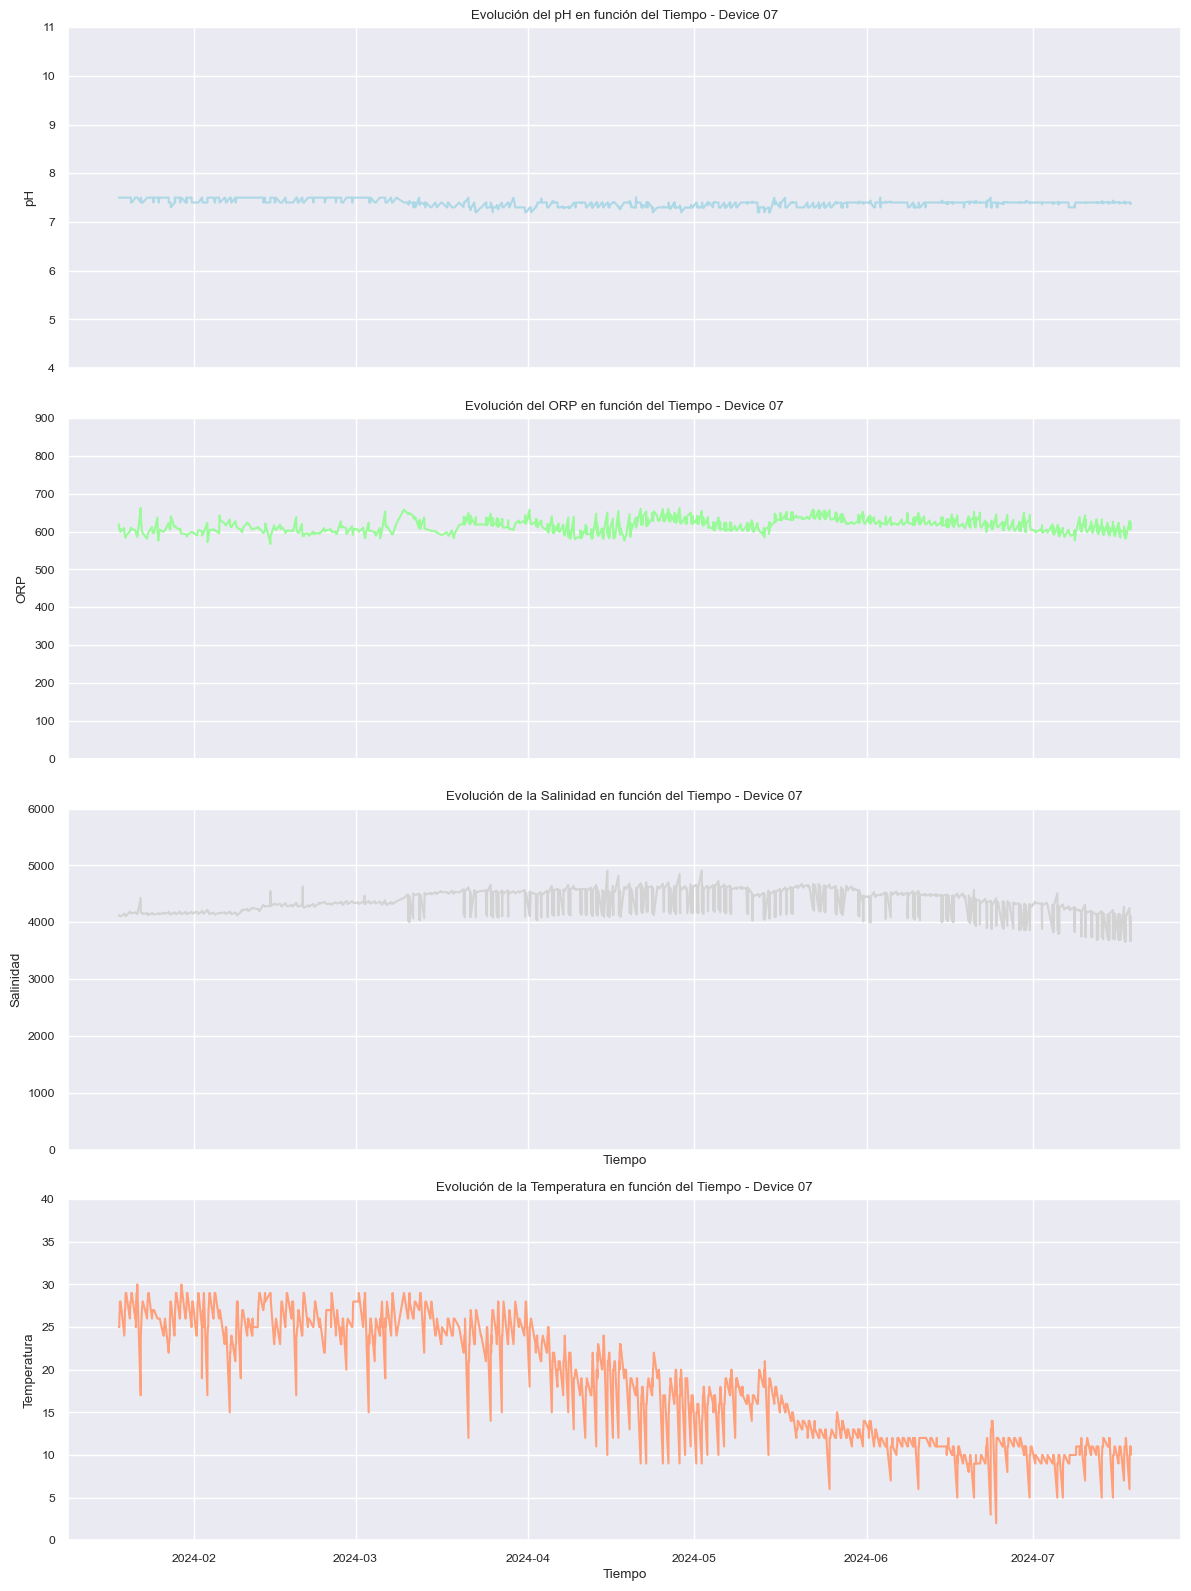

Datos limpios para Device10 guardados en datos_limpios_Device10.csv

Estadísticas Device10:
                PH          ORP     Salinity  Temperature
count  1011.000000  1011.000000  1011.000000  1011.000000
mean      7.651345   648.280910  4280.133531    25.962413
std       0.478042    17.964162   125.888340     2.615372
min       7.300000   596.000000  4006.000000    16.000000
25%       7.400000   641.000000  4205.500000    24.000000
50%       7.400000   644.000000  4247.000000    26.000000
75%       7.600000   656.000000  4295.000000    28.000000
max       9.300000   716.000000  4527.000000    30.000000
Porcentaje de datos conservados para Device10: 65.10%
Imagen guardada como ParametrosVSTiempo_Device10.png


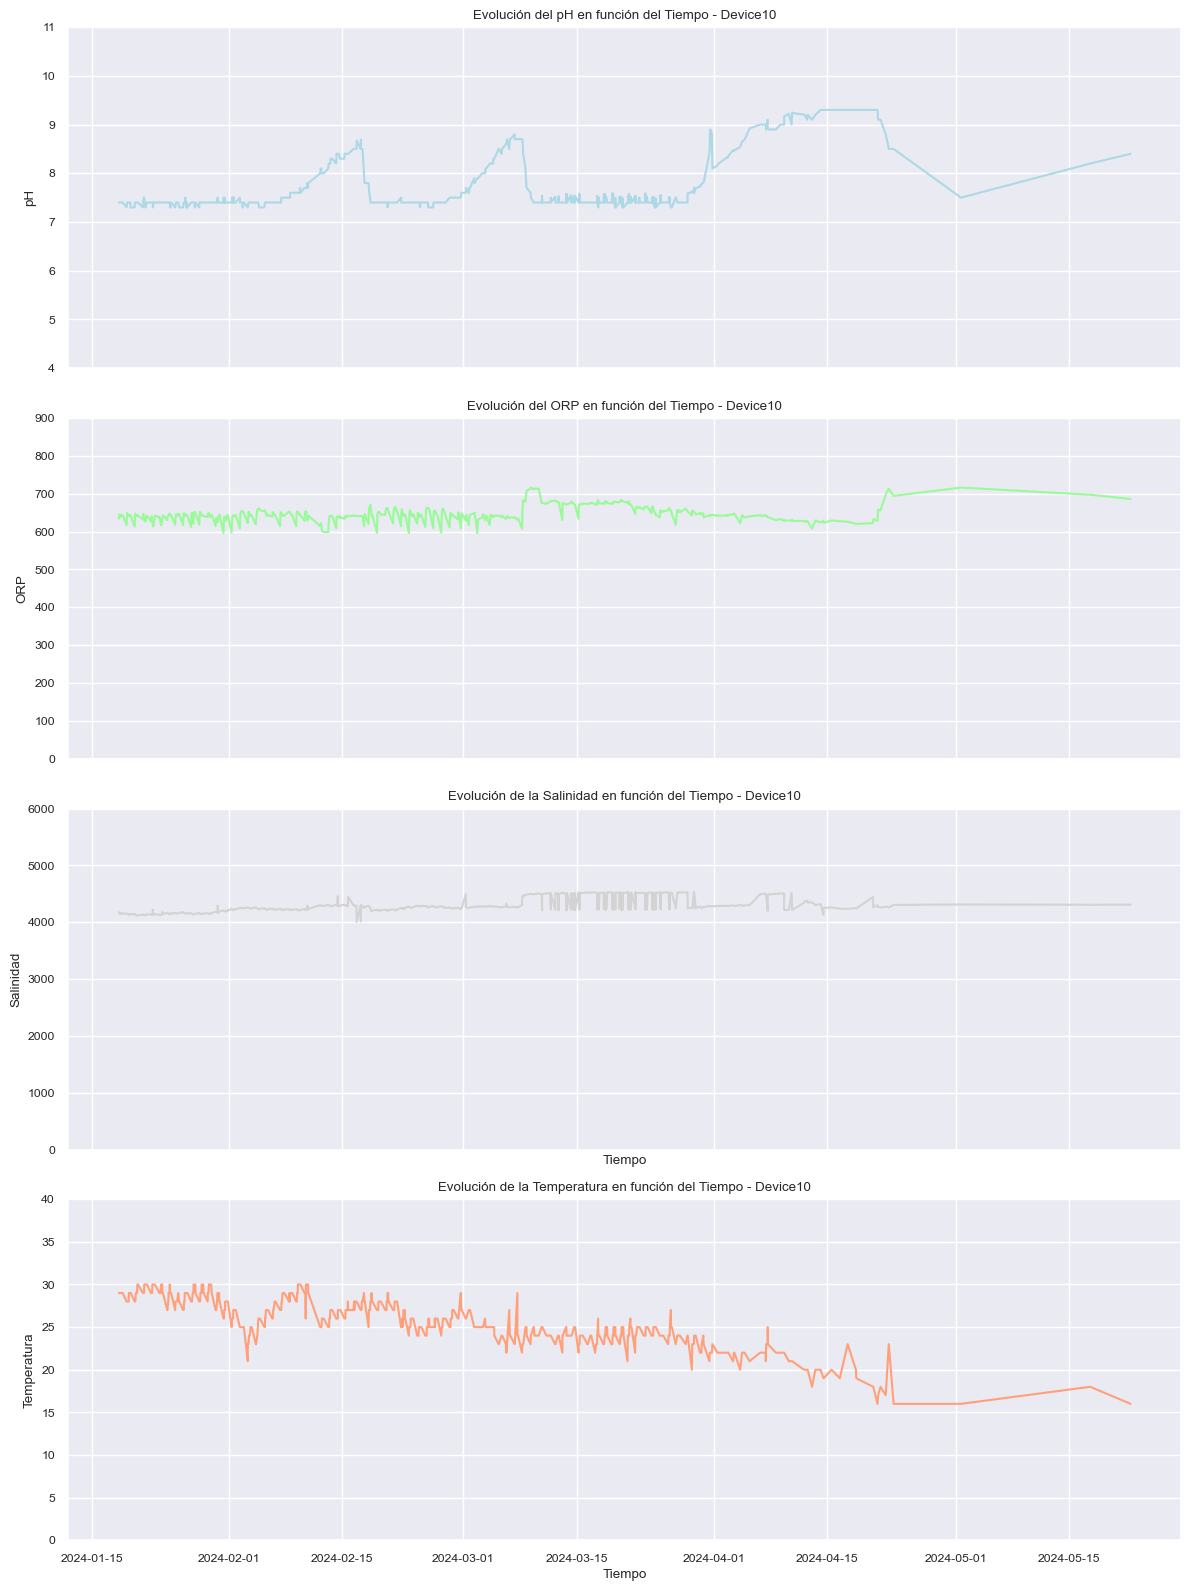

Todos los datos limpios guardados en DatosProcesados.csv


In [36]:
# Limpieza y representacion de todos los devices
def outliers(df, columns):
    df_clean = df.copy()
    for column in columns:
        Q1 = df_clean[column].quantile(0.25)
        Q3 = df_clean[column].quantile(0.75)
        IQR = Q3 - Q1
        limiteQ1 = Q1 - 1.5 * IQR
        limiteQ3 = Q3 + 1.5 * IQR 
        df_clean = df_clean[(df_clean[column] >= limiteQ1) & (df_clean[column] <= limiteQ3)]
    return df_clean

param = parameters

# Colores para las gráficas personalizados, los hacemos mas user friendly 
colors = {'PH': '#ADD8E6',
    'ORP': '#98FB98',
    'Salinity': '#D3D3D3'}

DataProcesado = pd.DataFrame()

# Creamos un buble for por cada dispositivo ya que cada piscina tiene un set point y un tamaño diferente y esto podria afectar a los valores, hay que tratarlos de manera diferente
for device in devices:
    df_device = df[df['Device'] == device]
    
    # Llamamos a la funcion outliers
    df_clean = outliers(df_device, param)
    # Añadir y guardar los datos limpios al DataFrame general
    DataProcesado = pd.concat([DataProcesado, df_clean], ignore_index=True) 
    all_devices_dataclean = pd.concat([DataProcesado, df_clean], ignore_index=True)
    csv_filename = f'datos_limpios_{device}.csv'
    df_clean.to_csv(csv_filename, index=False)
    print(f"Datos limpios para {device} guardados en {csv_filename}")

    print(f"\nEstadísticas {device}:")
    print(df_clean[param].describe())
    percent_kept = (len(df_clean) / len(df_device)) * 100
    print(f"Porcentaje de datos conservados para {device}: {percent_kept:.2f}%")
    
    # Graficas per device
    df_clean['Time'] = pd.to_datetime(df_clean['Time'])
    df_clean = df_clean.sort_values(by='Time')
    
    fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True)
    
    # pH
    axes[0].plot(df_clean['Time'], df_clean['PH'], linestyle='-', color=colors['PH'])
    axes[0].set_title(f'Evolución del pH en función del Tiempo - {device}')
    axes[0].set_ylim(4, 11)
    axes[0].set_ylabel('pH')
    axes[0].grid(True)
    
    # ORP
    axes[1].plot(df_clean['Time'], df_clean['ORP'], linestyle='-', color=colors['ORP'])
    axes[1].set_title(f'Evolución del ORP en función del Tiempo - {device}')
    axes[1].set_ylim(0, 900)
    axes[1].set_ylabel('ORP')
    axes[1].grid(True)
    
    # Salinity
    axes[2].plot(df_clean['Time'], df_clean['Salinity'], linestyle='-', color=colors['Salinity'])
    axes[2].set_title(f'Evolución de la Salinidad en función del Tiempo - {device}')
    axes[2].set_ylim(0, 6000)
    axes[2].set_xlabel('Tiempo')
    axes[2].set_ylabel('Salinidad')
    axes[2].grid(True)

    # Temperatura
    axes[3].plot(df_clean['Time'], df_clean['Temperature'], linestyle='-', color='#FFA07A')
    axes[3].set_title(f'Evolución de la Temperatura en función del Tiempo - {device}')
    axes[3].set_ylim(0, 40)  
    axes[3].set_ylabel('Temperatura')
    axes[3].set_xlabel('Tiempo')
    axes[3].grid(True)
    
    plt.tight_layout()
    
    # Guardar cada imagen generada
    filename = f'ParametrosVSTiempo_{device}.png'
    plt.savefig(filename, dpi=300)
    print(f"Imagen guardada como {filename}")
    plt.show()

# Guardamos todos los datos limpios en un solo archivo CSV
DataProcesado['Time'] = pd.to_datetime(DataProcesado['Time'])
DataProcesado.to_csv('DatosProcesados.csv', index=False)
print("Todos los datos limpios guardados en DatosProcesados.csv")


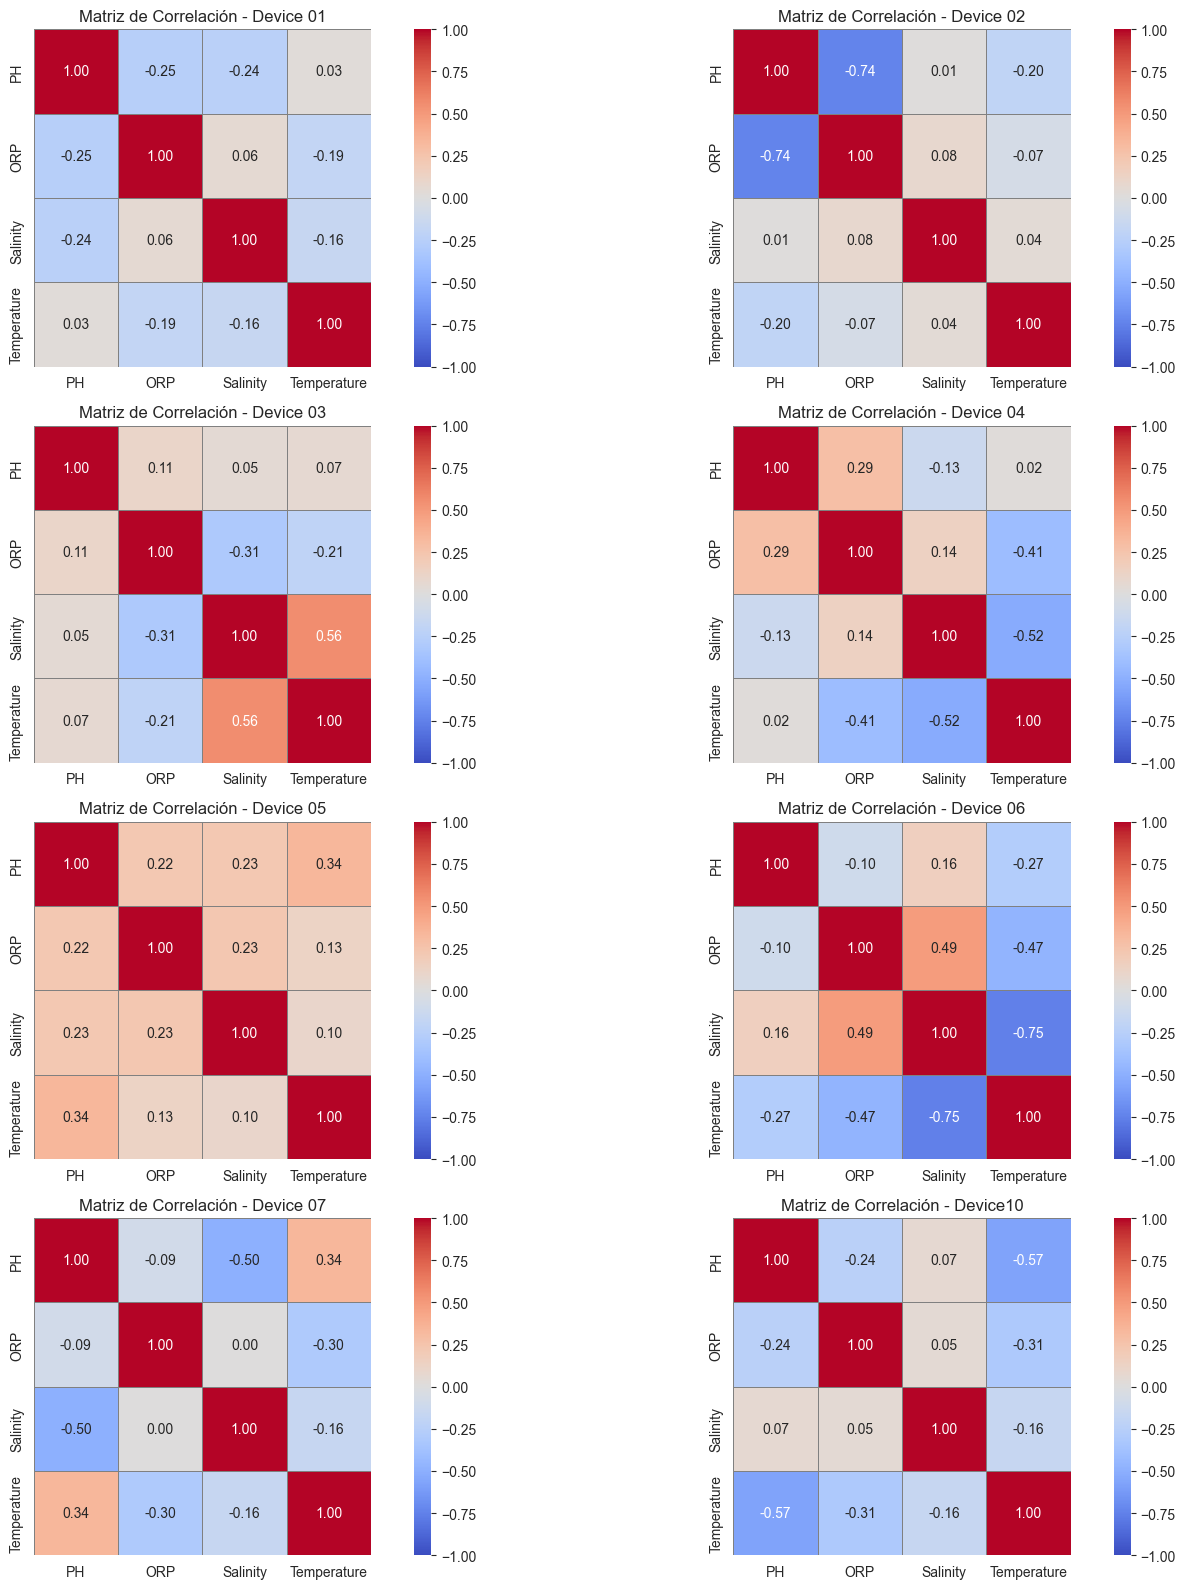

In [28]:
#Matriz de correlaciones
sns.set_style("whitegrid")
n_rows = (len(devices) + 1) // 2  # Número de filas en el subplot

# Crear subplots para las matrices de correlación
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(16, 4 * n_rows))

for i, device in enumerate(devices):
    df_device = df[df['Device'] == device]
    correlation_matrix = df_device[param].corr()
    
    # subplot 
    ax = axes[i // 2, i % 2]

    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", ax=ax, cbar=True, 
                vmin=-1, vmax=1, center=0, square=True, linewidths=0.5, linecolor='gray')
    ax.set_title(f'Matriz de Correlación - {device}')

plt.tight_layout()
plt.savefig('matrices_de_correlacion.png', dpi=300)
plt.show()

- pH: El rango ideal de pH para una piscina es de 7.2 a 7.8. Un pH dentro de este rango ayuda a asegurar la eficacia de los productos químicos, evita la corrosión y previene problemas en la piel y los ojos de los nadadores.

- ORP (Potencial de Oxidorreducción): Para una piscina con cloro, el ORP debería estar entre 600 y 750 mV. Un valor más alto indica un mayor nivel de desinfectante en el agua, lo que puede ayudar a mantener el agua limpia y libre de microorganismos.

- Salinidad: Para piscinas con sistemas de cloración salina, la salinidad generalmente debe estar entre 2,500 y 4,000 ppm (partes por millón). La cantidad exacta puede variar según el sistema de cloración utilizado, por lo que es importante seguir las recomendaciones del fabricante. Nuestro sistema llega a funcionar desde 1000 a 6000ppm. 

Usamos la grafica del PH para ver un poco el funcionamiento del sistema a la hora de tomar datos. Este projecto se esta realizando con el data recolectado durante los ultimos 6 meses de 10 piscinas con diferentes tamanios en Australia, todas ellas tienen instalado un sistema Lifeguard que se constituye de un clorificador de agua por salinidad, este dispositivo no bombea agua todo el rato pero si se toman muestras cada 15 minutos , sin embargo las muestras que se toman cuando la bomba no esta en funcionamiento no son precisas ni reales, como podemos observar esto? en los intervalos que vemos que el flujo es 0 el PH tiene valores inconsistentes para una piscina donde los rangos adecuados para la salido van entre 7.2 y 7.8 todo por encima o debajo de ello no es recomendable y tampoco es posible dado que el sitema tambien tiene unas alarmas que indican si realmente la piscina estuviera fuera de estos rangos y si fuera asi habrian saltado todo el rato. Estos sitemas funcionan unas 8h al dia donde la bomba se enciende y apaga intermitentemente para adaptarse a los niveles optimos, estas horas de funcionamiento suelen estar regidas por uno o dos ciclos, es decir ocurren o en un solo periodo del dia o en dos. Pero ademas debido a su alto gasto podria ser que el usuario decidiera apagarlo, dado que para que el el flow funcione la bomba tiene que estar en uso y es un gran gasto lo que en momentos mas de invierno o periodos de vacaciones el usuario podria tener esto desconectado, pero se seguirian tomando muestras del agua residual dentro del clorificador. 

pH óptimo: 7.2 - 7.8
Este rango es ideal por varias razones:

Confort para los nadadores: Un pH dentro de este rango evita irritaciones en los ojos y la piel de los nadadores.

Eficiencia del cloro: El cloro (o cualquier otro desinfectante) es más efectivo en un pH ligeramente ácido a neutro (cercano a 7.4). Un pH muy alto o muy bajo puede reducir la eficacia del cloro.

Prevención de daños en el equipo: Un pH fuera de este rango puede causar corrosión en el equipo de la piscina o dejar depósitos de calcio.

Si el pH está por debajo de 7.2, puede ser necesario añadir un producto que eleve el pH (como bicarbonato de sodio). Si está por encima de 7.8, se debe usar un producto para reducir el pH (como ácido muriático o ácido sulfúrico).

Para un monitoreo regular, es recomendable revisar el pH de la piscina al menos dos veces por semana y ajustar según sea necesario.


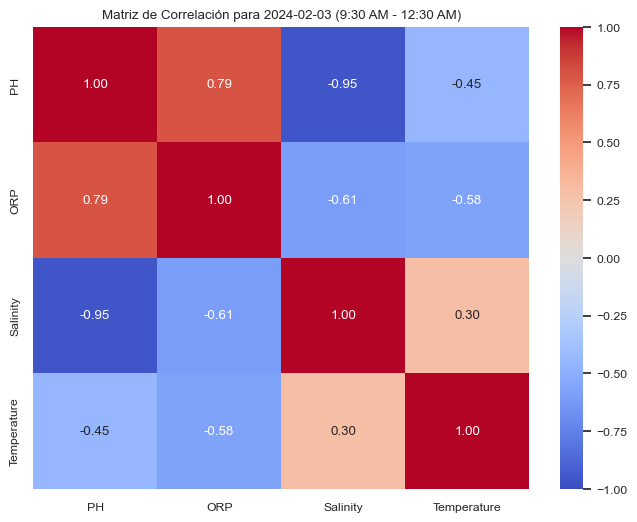

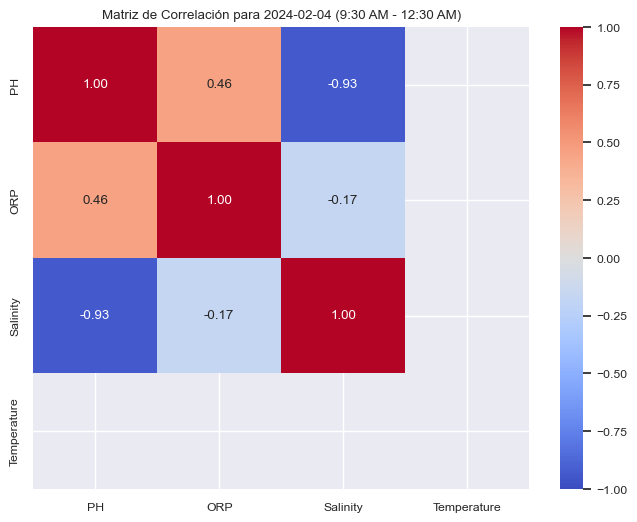

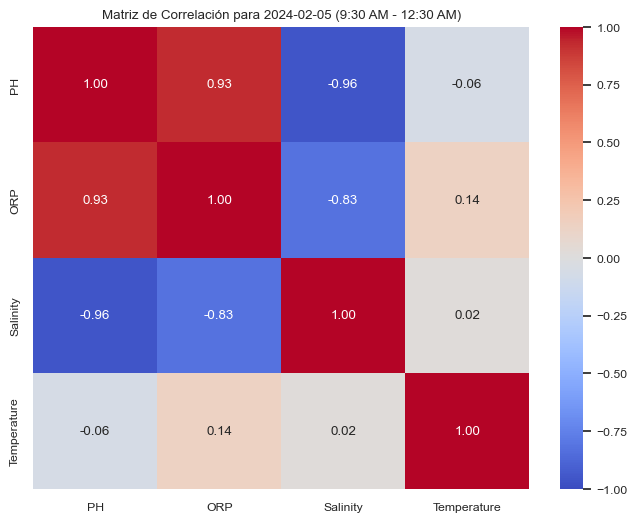

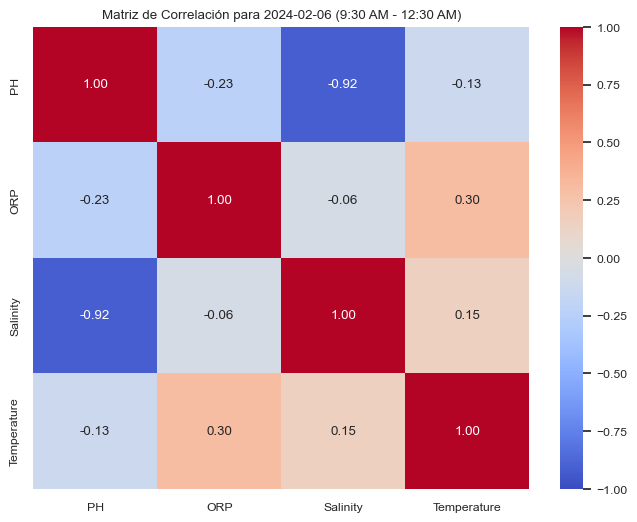

In [38]:
try:
    # fechas específicas
    df_device_4 = DataProcesado[(DataProcesado['Device'] == 'Device 04') &
                                (DataProcesado['Time'].dt.date >= pd.to_datetime('2024-02-03').date()) &
                                (DataProcesado['Time'].dt.date <= pd.to_datetime('2024-02-06').date())].copy()

    for col in parameters:
        df_device_4[col] = pd.to_numeric(df_device_4[col], errors='coerce')

    # Rango de tiempo de 9:30 a.m. a 11:30 a.m.
    df_filtered = df_device_4[(df_device_4['Time'].dt.time >= pd.to_datetime('09:30').time()) &
                              (df_device_4['Time'].dt.time < pd.to_datetime('11:30').time())]

    grouped = df_filtered.groupby(df_filtered['Time'].dt.date)

    for date, group in grouped:
        corr_matrix = group[parameters].corr()
        if not corr_matrix.empty:
            plt.figure(figsize=(8, 6))
            sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
            plt.title(f'Matriz de Correlación para {date} (9:30 AM - 12:30 AM)')
            plt.show()
        else:
            print(f"No hay suficientes datos para {date}.")

except Exception as e:
    print(f"Se produjo un error: {e}")

CONCLUSIONES MATRICES DE CORRELACION:

En las matrices de correlación observadas para el mismo dispositivo y en el mismo rango horario durante diferentes días, se aprecia una variabilidad significativa en las relaciones entre variables como el pH, ORP, salinidad y temperatura. Esta variabilidad puede explicarse por varios factores, siendo uno de los más relevantes la intervención del sistema de control. La variabilidad en las matrices de correlación destaca la influencia significativa del sistema de control en la dinámica del proceso. Al manipular activamente variables clave como el pH, se afecta la relación natural entre las variables monitorizadas. Esto sugiere que el sistema de control está operando de manera efectiva, aunque también introduce complejidades en la interpretación de las correlaciones debido a la intervención activa.

- Intervención del sistema de control
El sistema de control, al detectar un aumento en el pH, activa el acidificador para reducirlo y mantener el equilibrio deseado en la solución. Esta acción no solo ajusta el pH, sino que también altera las relaciones entre las demás variables, como el ORP y la salinidad. Esto ocurre porque el sistema está diseñado para mantener ciertas condiciones óptimas, lo que implica la manipulación activa de las variables para compensar cualquier desviación detectada. Por ejemplo, el ORP generalmente disminuye cuando el pH aumenta; sin embargo, esta relación puede verse alterada cuando el sistema interviene, lo que resulta en una correlación menos predecible.

- Variabilidad en las condiciones externas
Es importante considerar también que las condiciones ambientales, como la temperatura o la calidad del agua, pueden variar de un día a otro. Estas fluctuaciones externas pueden modificar la relación natural entre las variables, reflejándose en cambios en las matrices de correlación.

- Interacción compleja de variables
En un sistema controlado, las relaciones entre variables no son necesariamente lineales ni constantes. Las intervenciones del sistema para mantener el equilibrio pueden desencadenar una serie de ajustes en otras variables, complicando la interpretación de las correlaciones observadas. Esto es indicativo de un sistema dinámico, donde las acciones correctivas implementadas por el control pueden llevar a variaciones en las correlaciones de un día a otro.



Ejemplos de uso de Try - Except:
- Se produjo un error: Cannot compare Timestamp with datetime.date. Use ts == pd.Timestamp(date) or ts.date() == date instead.

